In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [3]:
dss = open_mncdataset('run_bump5000_barotrop/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_barotrop/grid', 2, 3, None)
dsbb=xr.merge((dss,dsg))
dsbb=dsbb.isel(Zp1=slice(0,-1))
dsbb['Z']=-1*dsbb.Z
dsbb['Zl']=-1*dsbb.Zl
dsbb=dsbb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbb = xgcm.generate_grid_ds(dsbb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbb.coords['day']=dsbb.T/(24*3600)
dsbb.coords['month']=dsbb.day/30

# equal t startification
dss = open_mncdataset('run_bump5000_20layers/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layers/grid', 2, 3, None)
dsb2u=xr.merge((dss,dsg))
dsb2u=dsb2u.isel(Zp1=slice(0,-1))
dsb2u['Z']=-1*dsb2u.Z
dsb2u['Zl']=-1*dsb2u.Zl
dsb2u=dsb2u.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2u = xgcm.generate_grid_ds(dsb2u, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2u.coords['day']=dsb2u.T/(24*3600)
dsb2u.coords['month']=dsb2u.day/30

# add meridional gradient to equal stratficiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_20layerswdTdy_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_tw/grid', 2, 3, None)
dsb2t=xr.merge((dss,dsg))
dsb2t=dsb2t.isel(Zp1=slice(0,-1))
dsb2t['Z']=-1*dsb2t.Z
dsb2t['Zl']=-1*dsb2t.Zl
dsb2t=dsb2t.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2t = xgcm.generate_grid_ds(dsb2t, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2t.coords['day']=dsb2t.T/(24*3600)
dsb2t.coords['month']=dsb2t.day/30


# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_20layerswdTdy_u01tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_20layerswdTdy_u01tw/grid', 2, 3, None)
dsb2tu=xr.merge((dss,dsg))
dsb2tu=dsb2tu.isel(Zp1=slice(0,-1))
dsb2tu['Z']=-1*dsb2tu.Z
dsb2tu['Zl']=-1*dsb2tu.Zl
dsb2tu=dsb2tu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2tu=xgcm.generate_grid_ds(dsb2tu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2tu.coords['day']=dsb2tu.T/(24*3600)
dsb2tu.coords['month']=dsb2tu.day/30

# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_tw/grid', 2, 3, None)
dsbet=xr.merge((dss,dsg))
dsbet=dsbet.isel(Zp1=slice(0,-1))
dsbet['Z']=-1*dsbet.Z
dsbet['Zl']=-1*dsbet.Zl
dsbet=dsbet.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbet=xgcm.generate_grid_ds(dsbet, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbet.coords['day']=dsbet.T/(24*3600)
dsbet.coords['month']=dsbet.day/30
# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_u01tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_u01tw/grid', 2, 3, None)
dsbetu=xr.merge((dss,dsg))
dsbetu=dsbetu.isel(Zp1=slice(0,-1))
dsbetu['Z']=-1*dsbetu.Z
dsbetu['Zl']=-1*dsbetu.Zl
dsbetu=dsbetu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbetu=xgcm.generate_grid_ds(dsbetu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbetu.coords['day']=dsbetu.T/(24*3600)
dsbetu.coords['month']=dsbetu.day/30



# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_real_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_tw/grid', 2, 3, None)
dsbrt=xr.merge((dss,dsg))
dsbrt=dsbrt.isel(Zp1=slice(0,-1))
dsbrt['Z']=-1*dsbrt.Z
dsbrt['Zl']=-1*dsbrt.Zl
dsbrt=dsbrt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrt=xgcm.generate_grid_ds(dsbrt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrt.coords['day']=dsbrt.T/(24*3600)
dsbrt.coords['month']=dsbrt.day/30

# add to thermal wind a barotropic inflow condition
dss = open_mncdataset('run_bump5000_real_utw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_real_utw/grid', 2, 3, None)
dsbrtu=xr.merge((dss,dsg))
dsbrtu=dsbrtu.isel(Zp1=slice(0,-1))
dsbrtu['Z']=-1*dsbrtu.Z
dsbrtu['Zl']=-1*dsbrtu.Zl
dsbrtu=dsbrtu.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbrtu=xgcm.generate_grid_ds(dsbrtu, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbrtu.coords['day']=dsbrtu.T/(24*3600)
dsbrtu.coords['month']=dsbrtu.day/30

In [4]:
dsbb['drU']=dsbb.U.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
dsbb['drV']=dsbb.V.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbb, periodic=False, metrics=metrics)

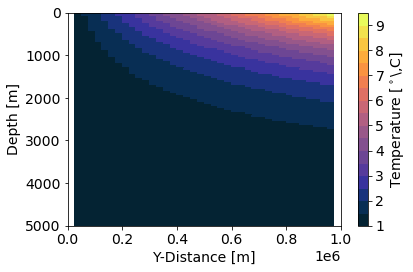

In [5]:
fig=plt.figure(figsize=(6,4))
dsbet.Temp.where(dsbet.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ$\,C]'})#,add_colorbar=False)
plt.ylabel('Depth [m]')
plt.xlabel('Y-Distance [m]')
plt.gca().invert_yaxis()
plt.title('')
plt.tight_layout()
plt.savefig('./figures/initial_caseD1.png')

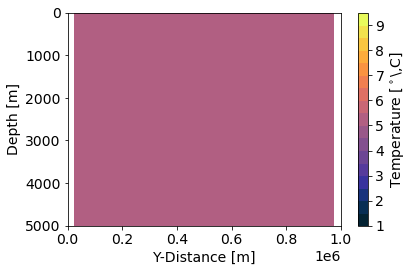

In [6]:
fig=plt.figure(figsize=(6,4))
dsbb.Temp.where(dsbb.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ$\,C]'})#,add_colorbar=False)
plt.ylabel('Depth [m]')
plt.xlabel('Y-Distance [m]')
plt.gca().invert_yaxis()
plt.title('')
plt.tight_layout()
plt.savefig('./figures/initial_caseA.png')

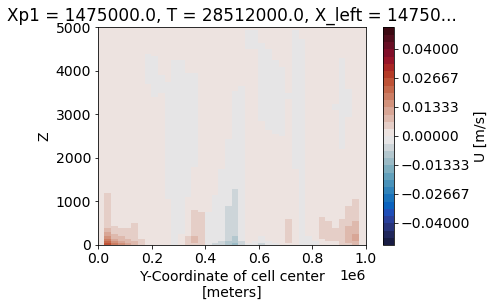

In [7]:
dsbrt.U.isel(T=11,X_left=59).plot.pcolormesh(vmin=-.05,vmax=0.05,levels=31,cmap=cmo.balance)

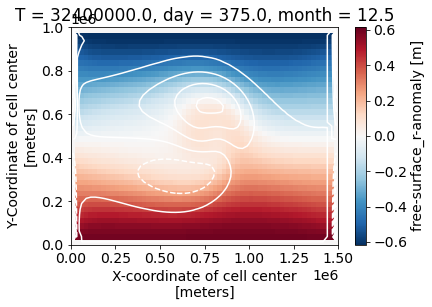

In [8]:
dsbb.Eta.isel(T=-1).plot.pcolormesh()
(dsbb.Eta.isel(T=-1)-dsbb.Eta.isel(T=-1,X=57)).plot.contour(levels=20,colors='w')

# Initial conditions

Text(0.5, 1.0, 'Gaussian Bump')

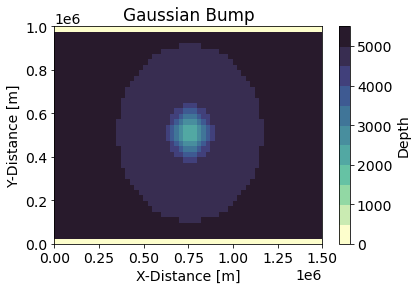

In [9]:
dsbb.Depth.plot.pcolormesh(vmin=0,vmax=5500,levels=12,cmap=cmo.deep)
plt.xlabel('X-Distance [m]')
plt.ylabel('Y-Distance [m]')
plt.title('Gaussian Bump')

Text(0.5, 1.0, 'e-scale ')

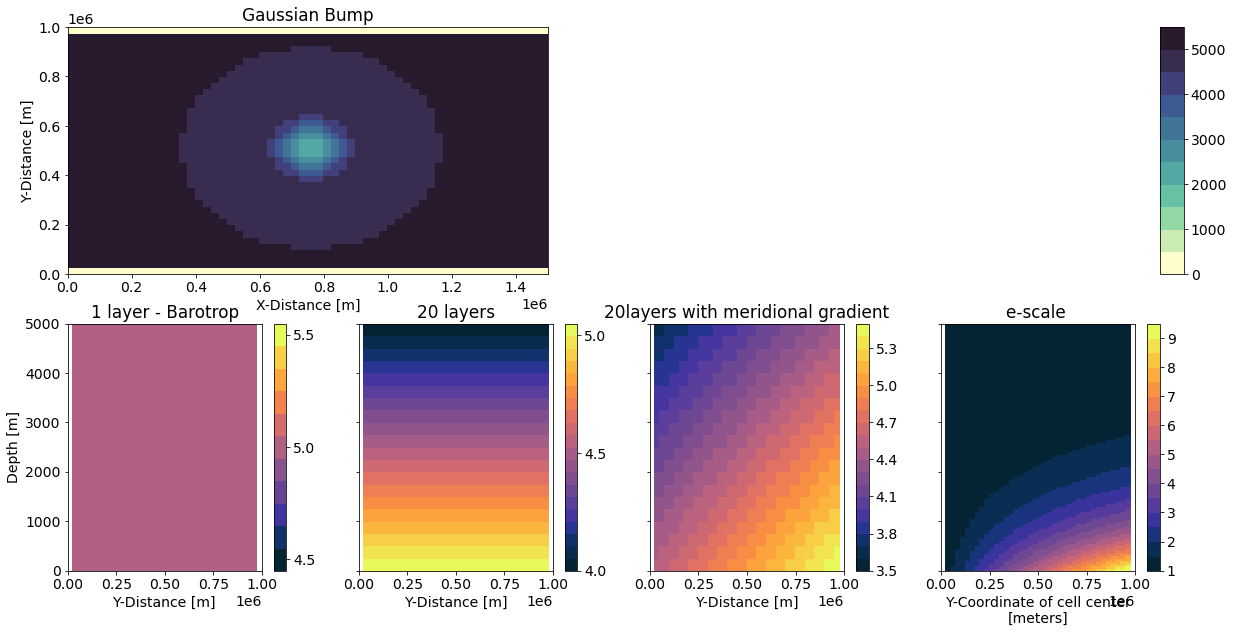

In [10]:
fig = plt.figure(figsize=(20,10))
gs = GridSpec(2,1, width_ratios=[1],wspace=.15)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(1,3, subplot_spec=gs[0,0], width_ratios=[1,1,.05])
gs2 = GridSpecFromSubplotSpec(1,4, subplot_spec=gs[1,0], width_ratios=[1,1,1,1])

ax1 = fig.add_subplot(gs1[0])#,sharey=ttc_m12)

cax_dep = fig.add_subplot(gs1[2])
ax3 = fig.add_subplot(gs2[0])#,sharey=ttc_m12)
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs2[2])
ax6 = fig.add_subplot(gs2[3])
#ax7 = fig.add_subplot(gs2[4])
# Plot used bathymetries
cb_dep=dsbb.Depth.plot.pcolormesh(vmin=0,vmax=5500,levels=12,ax=ax1,cmap=cmo.deep,add_colorbar=False)
ax1.set_xlabel('X-Distance [m]')
ax1.set_ylabel('Y-Distance [m]')
ax1.set_title('Gaussian Bump')
plt.colorbar(cb_dep,cax=cax_dep)

# Plot used temperature stratification
dsbb.Temp.where(dsbb.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.45,vmax=5.55,levels=12,cmap=cmo.thermal,ax=ax3,cbar_kwargs={'label':'','ticks':np.linspace(4.5,5.5,3)})#,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax4,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,ax=ax5,cmap=cmo.thermal,cbar_kwargs={'label':''})#,add_colorbar=False)
dsbet.Temp.where(dsbet.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,ax=ax6,cbar_kwargs={'label':''})#,add_colorbar=False)
#dsb2tu.Temp.where(dsb2tu.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,cmap=cmo.thermal,ax=ax7,cbar_kwargs={'label':'Temperature [$^\circ\,$C]'})#,add_colorbar=False)
ax3.set_xlabel('Y-Distance [m]')
ax3.set_ylabel('Depth [m]')
#ax3.set_yticklabels('')
ax3.set_title('1 layer - Barotrop')
ax4.set_xlabel('Y-Distance [m]')
ax4.set_ylabel('')
ax4.set_yticklabels('')
ax4.set_title('20 layers')
ax5.set_xlabel('Y-Distance [m]')
ax5.set_ylabel('')
ax5.set_yticklabels('')
ax5.set_title('20layers with meridional gradient')
ax6.set_ylabel('')
ax6.set_yticklabels('')
ax6.set_title('e-scale ')
#ax7.set_ylabel('')
#ax7.set_yticklabels('')
#ax7.set_title('20layers u=0.1+tw')
#plt.savefig('./figures/set_up.png',dpi=300)

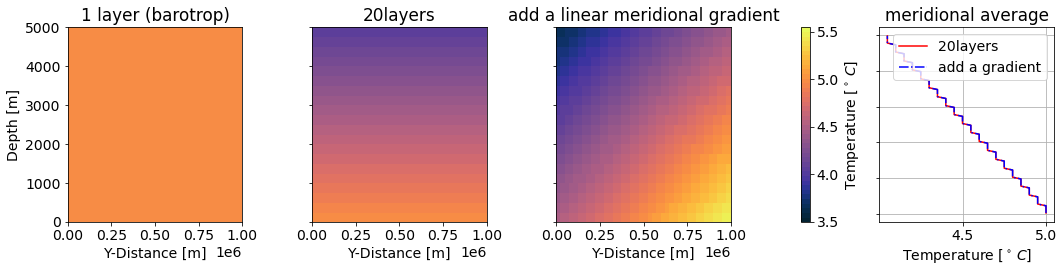

In [11]:
fig,axes=plt.subplots(1,5,figsize=(15,4),gridspec_kw={'width_ratios':[1,1,1,0.05,1]})

dsbb.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[0],vmin=3.5,vmax=5.55, levels=43,cmap=cmo.thermal,add_colorbar=False)#,vmin=4.05,vmax=5.05,levels=22)          
axes[0].set_title('1 layer (barotrop)')
axes[0].set_ylabel('Depth [m]')
axes[0].set_xlabel('Y-Distance [m]')

dsb2u.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[1],vmin=3.5,vmax=5.55, levels=43,cmap=cmo.thermal,add_colorbar=False)#,vmin=4.05,vmax=5.05,levels=22)          
axes[1].set_title('20layers')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_xlabel('Y-Distance [m]')
cb=dsb2t.Temp.isel(T=0,X=59).plot.pcolormesh(ax=axes[2],vmin=3.5,vmax=5.55,levels=43,cmap=cmo.thermal,add_colorbar=False)          
axes[2].set_title('add a linear meridional gradient')
axes[2].set_xlabel('Y-Distance [m]')
axes[2].set_ylabel('')
axes[2].set_yticklabels('')

plt.colorbar(cb,cax=axes[3],label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))

dsb2u.Temp.isel(T=0,X=59).mean(dim='Y').plot(y="Z",color='r',label='20layers',ax=axes[4])
dsb2t.Temp.isel(T=0,X=59).mean(dim='Y').plot(y="Z",color='b',ls='-.',label='add a gradient',ax=axes[4])
axes[4].set_ylabel('')
axes[4].set_xlabel('Temperature [$^\circ\,C$]')
axes[4].set_yticklabels('')
axes[4].grid()
axes[4].legend()
axes[4].set_title('meridional average')
plt.tight_layout()

In [12]:
print(dsb2t.Temp.isel(T=0,X=59,Z=0).values)
(dsb2t.Temp.isel(T=0,X=59,Z=0)[-1]-dsb2t.Temp.isel(T=0,X=59,Z=0)[0]).values

[4.5125 4.5375 4.5625 4.5875 4.6125 4.6375 4.6625 4.6875 4.7125 4.7375
 4.7625 4.7875 4.8125 4.8375 4.8625 4.8875 4.9125 4.9375 4.9625 4.9875
 5.0125 5.0375 5.0625 5.0875 5.1125 5.1375 5.1625 5.1875 5.2125 5.2375
 5.2625 5.2875 5.3125 5.3375 5.3625 5.3875 5.4125 5.4375 5.4625 5.4875]


array(0.9750004, dtype=float32)

In [13]:
print(dsb2t.Temp.isel(T=0,X=59,Z=99).values)
(dsb2t.Temp.isel(T=0,X=59,Z=99)[-1]-dsb2t.Temp.isel(T=0,X=59,Z=99)[0]).values

[3.655125 3.675375 3.695625 3.715875 3.736125 3.756375 3.776625 3.796875
 3.817125 3.837375 3.857625 3.877875 3.898125 3.918375 3.938625 3.958875
 3.979125 3.999375 4.019625 4.039875 4.060125 4.080375 4.100625 4.120875
 4.141125 4.161375 4.181625 4.201875 4.222125 4.242375 4.262625 4.282875
 4.303125 4.323375 4.343625 4.363875 4.384125 4.404375 4.424625 4.444875]


array(0.78974986, dtype=float32)

## inflow conditions

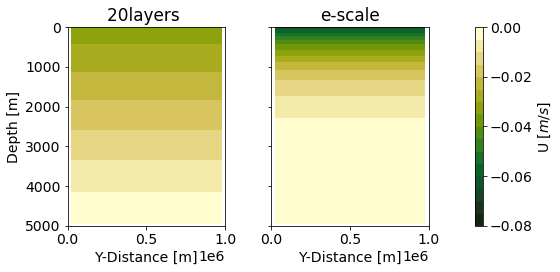

In [14]:

fig,axes=plt.subplots(1,3,figsize=(8,4),gridspec_kw={'width_ratios':[1,1,0.05]})
#
cb=dsb2t.U.isel(T=0,X_left=59).plot.pcolormesh(ax=axes[0],vmin=-.08,vmax=0,levels=17,cmap=cmo.speed_r,add_colorbar=False)          
axes[0].set_title('20layers ')
axes[0].set_xlabel('Y-Distance [m]')
axes[0].set_ylabel('Depth [m]')
axes[0].invert_yaxis()

cb=dsbet.U.isel(T=0,X_left=59).plot.pcolormesh(ax=axes[1],vmin=-.08,vmax=0,levels=17,cmap=cmo.speed_r,add_colorbar=False)          
axes[1].set_title('e-scale')
axes[1].set_xlabel('Y-Distance [m]')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].invert_yaxis()
plt.colorbar(cb,cax=axes[2],label='U [$m/s$]',ticks=np.linspace(-.08,0,5))
plt.tight_layout()


In [15]:
# Estimate mean u inflow 
print(np.round(dsbb.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2u.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2t.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsb2tu.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsbet.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))
print(np.round(dsbetu.U.isel(X_left=59,Y=slice(1,-1),T=0).mean(dim={"Y","Z"}).values,3))

-0.1
-0.1
-0.016
-0.116
-0.012
-0.112


# Initial stratficiation

In [16]:
alpha0=1e-4
rho0=1035

dsbb['rho']  =rho0- rho0*alpha0*dsbb.Temp.where(dsbb.S!=0)
dsb2u['rho'] =rho0- rho0*alpha0*dsb2u.Temp.where(dsb2u.S!=0)
dsb2t['rho'] =rho0- rho0*alpha0*dsb2t.Temp.where(dsb2t.S!=0)
dsb2tu['rho']=rho0- rho0*alpha0*dsb2tu.Temp.where(dsb2tu.S!=0)
dsbet['rho'] =rho0- rho0*alpha0*dsbet.Temp.where(dsbet.S!=0)
dsbetu['rho']=rho0- rho0*alpha0*dsbetu.Temp.where(dsbetu.S!=0)
dsbrt['rho'] =rho0- rho0*alpha0*dsbrt.Temp.where(dsbrt.S!=0)
dsbrtu['rho']=rho0- rho0*alpha0*dsbrtu.Temp.where(dsbrtu.S!=0)


In [17]:
dsbb['rho_hm']  =  dsbb.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2u['rho_hm'] = dsb2u.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2t['rho_hm'] = dsb2t.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsb2tu['rho_hm']=dsb2tu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbet['rho_hm'] = dsbet.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbetu['rho_hm']=dsbetu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbrt['rho_hm'] = dsbrt.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})
dsbrtu['rho_hm']=dsbrtu.rho.isel(Y=slice(1,-1),T=0).mean(dim={"X","Y"})

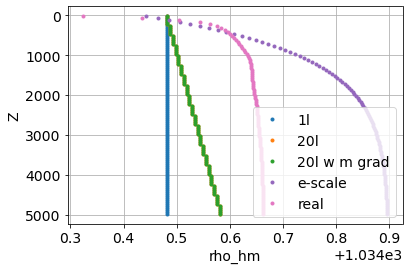

In [18]:
dsbb.rho_hm.plot(y="Z",label='1l',ls='',marker='.')
dsb2u.rho_hm.plot(y="Z", label='20l',ls='',marker='.')
dsb2t.rho_hm.plot(y="Z",label="20l w m grad",ls='',marker='.')
dsb2tu.rho_hm.plot(y="Z",label="",ls='',marker='.',alpha=0)
dsbet.rho_hm.plot(y="Z", label="e-scale",ls='',marker='.')
dsbetu.rho_hm.plot(y="Z",label="",ls='',marker='.',alpha=0)
dsbrt.rho_hm.plot(y="Z", label="real",ls='',marker='.')
dsbrtu.rho_hm.plot(y="Z",label="",ls='',marker='.',alpha=0)
plt.legend(loc="lower right")
plt.grid()
plt.gca().invert_yaxis()

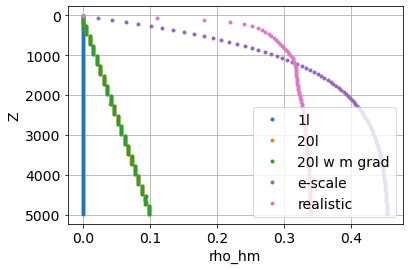

In [19]:
(dsbb.rho_hm-dsbb.rho_hm.isel(Z=0)).plot(y="Z",label='1l',ls='',marker='.')
(dsb2u.rho_hm-dsb2u.rho_hm.isel(Z=0)).plot(y="Z", label='20l',ls='',marker='.')
(dsb2t.rho_hm-dsb2t.rho_hm.isel(Z=0)).plot(y="Z",label="20l w m grad",ls='',marker='.')
(dsb2tu.rho_hm-dsb2tu.rho_hm.isel(Z=0)).plot(y="Z",label="",ls='',marker='.',alpha=0)
(dsbet.rho_hm-dsbet.rho_hm.isel(Z=0)).plot(y="Z", label="e-scale",ls='',marker='.')
(dsbetu.rho_hm-dsbetu.rho_hm.isel(Z=0)).plot(y="Z",label="",ls='',marker='.',alpha=0)
(dsbrt.rho_hm-dsbrt.rho_hm.isel(Z=0)).plot(y="Z", label="realistic",ls='',marker='.')
(dsbrtu.rho_hm-dsbrtu.rho_hm.isel(Z=0)).plot(y="Z",label="",ls='',marker='.',alpha=0)
plt.legend(loc="lower right")
plt.grid()
plt.gca().invert_yaxis()

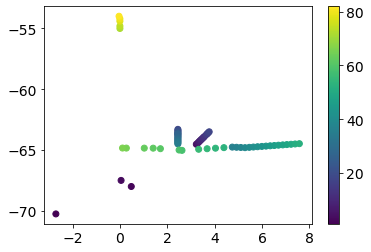

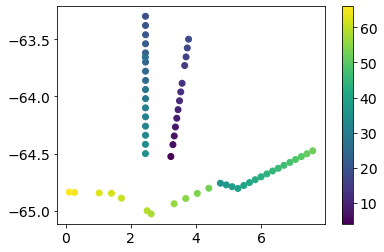

In [20]:
ds_ctd=xr.open_dataset('/home/birte/observation/SO_CHIC_CTD/SOCHIC_CTD_26082022.nc')
ds_ctd.coords['depth']=-1*(gsw.z_from_p(ds_ctd.pressure,ds_ctd.Latitude))
ds_ctd['pottemp']=gsw.pt0_from_t(gsw.SA_from_SP(ds_ctd.PSAL,ds_ctd.pressure,ds_ctd.Longitude,ds_ctd.Latitude),ds_ctd.TEMP,ds_ctd.pressure)
ds_ctd
# interpolate data onto 1m bins and create a new dataset with it
dim_3D = ("station","depth")
dim_2D = ("station")
z_int=np.arange(0,6000,1)
temi=np.zeros([len(ds_ctd.station),len(z_int)])
sali=np.zeros([len(ds_ctd.station),len(z_int)])
for i in range(0,len(ds_ctd.station)):
    temi[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.pottemp.isel(station=i))
    sali[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.PSAL.isel(station=i))
dso= xr.Dataset(
        data_vars=dict(T_grided=(dim_3D, temi), S_grided=(dim_3D, sali),lat=(dim_2D,ds_ctd.Latitude),lon=(dim_2D,ds_ctd.Longitude)),
                   coords=dict(
            station= (["station"],ds_ctd.station),
            depth = (["depth"],z_int)
            )
        )
dso['rho_nl']=gsw.rho(dso.S_grided,dso.T_grided,0)

dso['depth']=dso.depth
plt.figure()
plt.scatter(dso.lon,dso.lat,c=dso.station)
plt.colorbar()
#removing data points at the beginning and end of cruise
dso=dso.isel(station=slice(3,-5))
plt.figure()
plt.scatter(dso.lon,dso.lat,c=dso.station)
plt.colorbar()

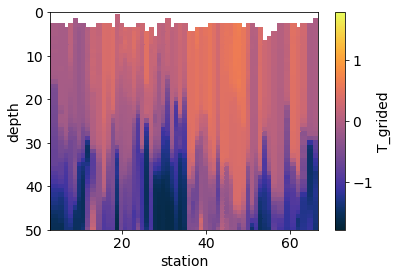

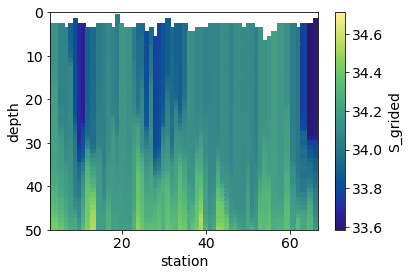

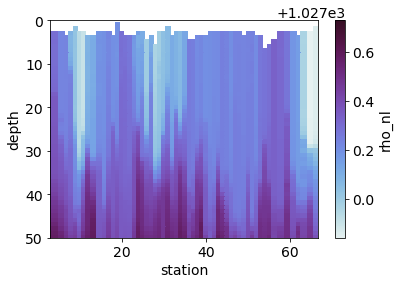

In [21]:
ym=50
plt.figure()
dso.T_grided.plot.pcolormesh(x="station",cmap=cmo.thermal)
plt.ylim(0,ym)
plt.gca().invert_yaxis()
plt.figure()
dso.S_grided.plot.pcolormesh(x="station",cmap=cmo.haline)
plt.ylim(0,ym)
plt.gca().invert_yaxis()
plt.figure()
dso.rho_nl.plot.pcolormesh(x="station",cmap=cmo.dense)
plt.ylim(0,ym)
plt.gca().invert_yaxis()


<ipython-input-22-8a8cc6791c56>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


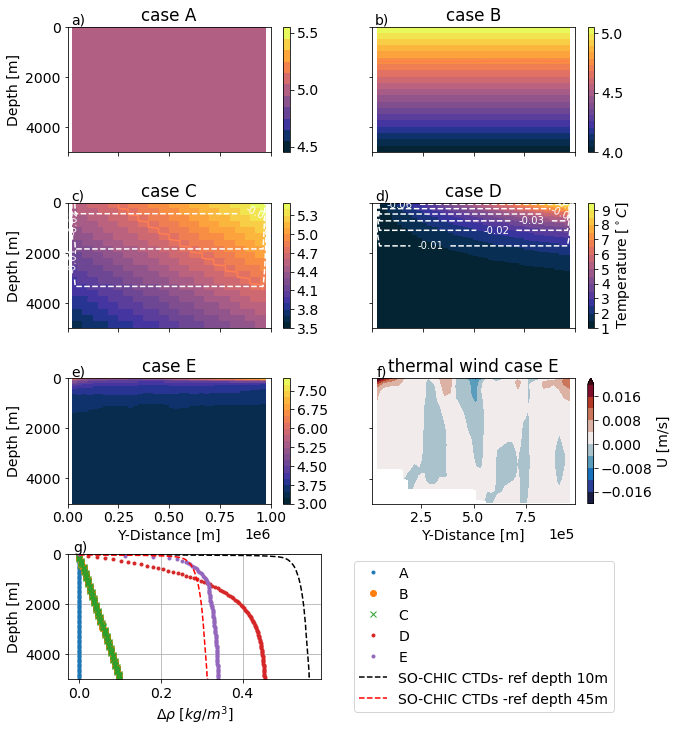

In [22]:
## dsbet.Temp.where(dsbet.Temp>0).isel(X=10,Tfig = plt.figure(figsize=(20,10))

fig,axes=plt.subplots(4,2, figsize=(10,12),gridspec_kw={'width_ratios':[1,1],'hspace':.4})

ax0 = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[1,0]
ax3 = axes[1,1]
ax31= axes[2,0]
ax32= axes[2,1]
ax4 = axes[3,0]
#axes[2,1].axis('off')
axes[3,1].axis('off')

# Plot used bathymetries

# Plot used temperature stratification
dsbb.Temp.where(dsbb.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.45,vmax=5.55,levels=12,cmap=cmo.thermal,ax=ax0,cbar_kwargs={'label':'','ticks':np.linspace(4.5,5.5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax1,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=10,X=10).plot.contour(ax=ax1,colors=['coral'],levels=[4.75])
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,ax=ax2,cmap=cmo.thermal,cbar_kwargs={'label':''})#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.contour(levels=[4.75],ax=ax2,colors=['coral'])
dsbet.Temp.where(dsbet.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,ax=ax3,cbar_kwargs={'label':'Temperature [$^\circ C$]'})#,add_colorbar=False)
cs1=dsb2t.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.06,0,7),ax=ax2,colors='w')
cs2=dsbet.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.1,0,11),ax=ax3,colors='w')
ax2.clabel(cs1, cs1.levels, inline=True,fontsize=10,fmt='%.2f')
ax3.clabel(cs2, cs2.levels, inline=True,fontsize=10,fmt='%.2f')

dsbrt.Temp.where(dsbrt.S>0).isel(X=10,T=0).plot.pcolormesh(vmin=3,vmax=8,levels=21,ax=ax31,cmap=cmo.thermal,cbar_kwargs={'label':''})#,add_colorbar=False)
#dsbrt.Temp.where(dsbrt.S>0).isel(X=10,T=0).plot.contour(levels=[0],ax=ax31,colors=['coral']) 
dsbrt.U.where(dsbrt.U!=0).isel(X_left=59,T=0).plot.contourf(levels=np.linspace(-0.02,0.02,11),ax=ax32,cmap=cmo.balance)
#ax31.clabel(cs3, cs3.levels, inline=True,fontsize=10,fmt='%.2f')

(dsbb.rho_hm-dsbb.rho_hm.isel(Z=0)).plot(y="Z",ax=ax4,label='A',ls='',marker='.')
(dsb2u.rho_hm-dsb2u.rho_hm.isel(Z=0)).plot(y="Z",ax=ax4,label='B',ls='',marker='o')
(dsb2t.rho_hm-dsb2t.rho_hm.isel(Z=0)).plot(y="Z",ax=ax4,label="C",ls='',marker='x')
(dsbet.rho_hm-dsbet.rho_hm.isel(Z=0)).plot(y="Z",ax=ax4,label="D",ls='',marker='.')

(dsbrt.rho_hm-dsbrt.rho_hm.isel(Z=0)).plot(y="Z",ax=ax4,label="E",ls='',marker='.')
(dso.rho_nl.mean("station").isel(depth=slice(10,None,None))-dso.rho_nl.mean("station").isel(depth=10)).plot(y="depth",color="k",ax=ax4,ls="--", label="SO-CHIC CTDs- ref depth 10m")
(dso.rho_nl.mean("station").isel(depth=slice(45,None,None))-dso.rho_nl.mean("station").isel(depth=45)).plot(y="depth",color="r",ax=ax4,ls="--", label="SO-CHIC CTDs -ref depth 45m")
ax4.grid()
ax4.set_xlabel('$\Delta \\rho$ [$kg/ m^3$]')
ax4.set_ylabel('Depth [m]')
ax4.set_ylim(5000,0)
ax4.legend(bbox_to_anchor=[1.1,1])
ax4.set_title('')

ax0.set_xlabel('')
ax0.set_ylabel('Depth [m]')
ax0.set_title('case A')
ax0.set_xticklabels('')

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_yticklabels('')
ax1.set_xticklabels('')
ax1.set_title('case B')

ax2.set_xlabel('')
ax2.set_ylabel('Depth [m]')
ax2.set_xticklabels('')
ax2.set_title('case C')

ax3.set_xlabel('Y-Distance [m]')
ax3.set_ylabel('')
ax3.set_xticklabels('')
ax3.set_yticklabels('')
ax3.set_title('case D')
ax3.set_xlabel('')

ax31.set_ylabel('Depth [m]')
ax31.set_title('case E')
ax31.set_xlabel('Y-Distance [m]')
ax31.ticklabel_format(axis='x', style='sci', scilimits=[-5,5])

ax32.set_yticklabels('')
ax32.set_ylabel('')
ax32.set_title('thermal wind case E')
ax32.set_xlabel('Y-Distance [m]')
ax32.ticklabel_format(axis='x', style='sci', scilimits=[-5,5])

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax31.invert_yaxis()
ax32.invert_yaxis()


ax0.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax0.transAxes)
ax1.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
ax2.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
ax3.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax3.transAxes)
ax31.text(0.05, 1.05,'e)', horizontalalignment='center',verticalalignment='center', transform=ax31.transAxes)
ax32.text(0.05, 1.05,'f)', horizontalalignment='center',verticalalignment='center', transform=ax32.transAxes)
ax4.text(0.05, 1.05, 'g)', horizontalalignment='center',verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()


plt.savefig('./figures/temp_uvel_setup_new.jpg',dpi=300)

/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-23-cbe82489a073>:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


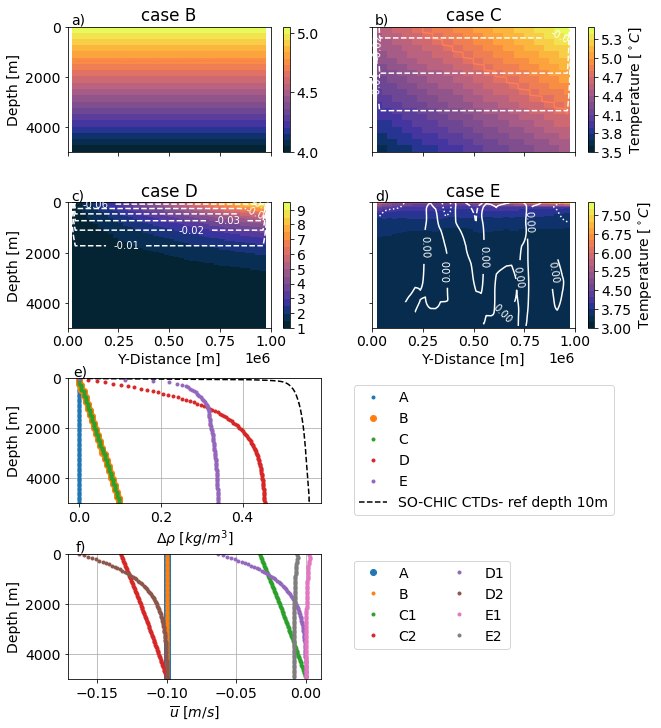

In [23]:
## dsbet.Temp.where(dsbet.Temp>0).isel(X=10,Tfig = plt.figure(figsize=(20,10))

fig,axes=plt.subplots(4,2, figsize=(10,12),gridspec_kw={'width_ratios':[1,1],'hspace':.4})

ax0 = axes[0,0]
ax1 = axes[0,1]
ax2 = axes[1,0]
ax3 = axes[1,1]
ax31= axes[2,0]
ax4 = axes[3,0]
axes[2,1].axis('off')
axes[3,1].axis('off')

# Plot used bathymetries

# Plot used temperature stratification
dsb2u.Temp.where(dsb2u.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,cmap=cmo.thermal,ax=ax0,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=10,X=10).plot.contour(ax=ax0,colors=['coral'],levels=[4.75])
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.5,levels=21,ax=ax1,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ C$]'})#,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(X=10,T=0).plot.contour(levels=[4.75],ax=ax1,colors=['coral'])
dsbet.Temp.where(dsbet.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=9.5,levels=18,cmap=cmo.thermal,ax=ax2,cbar_kwargs={'label':''})#,add_colorbar=False)
cs1=dsb2t.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.06,0,7),ax=ax1,colors='w')
cs2=dsbet.U.isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.1,0,11),ax=ax2,colors='w')
ax1.clabel(cs1, cs1.levels, inline=True,fontsize=10,fmt='%.2f')
ax2.clabel(cs2, cs2.levels, inline=True,fontsize=10,fmt='%.2f')

dsbrt.Temp.where(dsbrt.S>0).isel(X=10,T=0).plot.pcolormesh(vmin=3,vmax=8,levels=21,ax=ax3,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ C$]'})#,add_colorbar=False)
cs4=dsbrt.U.where(dsbrt.U!=0).isel(X_left=59,T=0).plot.contour(levels=np.linspace(-0.005,0.005,3),ax=ax3,linestyles=['--','-',':'],colors='w')
ax3.clabel(cs4, cs4.levels, inline=True,fontsize=10,fmt='%.2f')

# density profiles
(dsbb.rho_hm-dsbb.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label='A',ls='',marker='.')
(dsb2u.rho_hm-dsb2u.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label='B',ls='',marker='o')
(dsb2t.rho_hm-dsb2t.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="C",ls='',marker='.')
(dsbet.rho_hm-dsbet.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="D",ls='',marker='.')
(dsbrt.rho_hm-dsbrt.rho_hm.isel(Z=0)).plot(y="Z",ax=ax31,label="E",ls='',marker='.')
(dso.rho_nl.mean("station").isel(depth=slice(10,None,None))-dso.rho_nl.mean("station").isel(depth=10)).plot(y="depth",color="k",ax=ax31,ls="--", label="SO-CHIC CTDs- ref depth 10m")
#(dso.rho_nl.mean("station").isel(depth=slice(45,None,None))-dso.rho_nl.mean("station").isel(depth=45)).plot(y="depth",color="r",ax=ax31,ls="--", label="SO-CHIC CTDs -ref depth 45m")
ax31.grid()
ax31.set_xlabel('$\Delta \\rho$ [$kg/ m^3$]')
ax31.set_ylabel('Depth [m]')
ax31.set_ylim(5000,0)
ax31.legend(bbox_to_anchor=[1.1,1])
ax31.set_title('')

# velocity profiles
(dsbb.U.where(dsbb.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='A',ls='',marker='o')
(dsb2u.U.where(dsb2u.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='B',ls='',marker='.')
(dsb2t.U.where(dsb2t.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="C1",ls='',marker='.')
(dsb2tu.U.where(dsb2tu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="C2",ls='',marker='.')
(dsbet.U.where(dsbet.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="D1",ls='',marker='.')
(dsbetu.U.where(dsbetu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="D2",ls='',marker='.')
(dsbrt.U.where(dsbrt.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="E1",ls='',marker='.')
(dsbrtu.U.where(dsbrtu.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label="E2",ls='',marker='.')
ax4.grid()
ax4.set_xlabel('$\overline{u}$ [$m/s$]')
ax4.set_ylabel('Depth [m]')
ax4.set_ylim(5000,0)
ax4.legend(bbox_to_anchor=[1.1,1], ncol=2)
ax4.set_title('')

ax0.set_xlabel('')
ax0.set_ylabel('Depth [m]')
ax0.set_title('case B')
ax0.set_xticklabels('')

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.set_title('case C')

ax2.set_xlabel('Y-Distance [m]')
ax2.set_ylabel('Depth [m]')
ax2.set_title('case D')

ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_yticklabels('')
ax3.set_title('case E')
ax3.set_xlabel('Y-Distance [m]')



ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax32.invert_yaxis()


ax0.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax0.transAxes)
ax1.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
ax2.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
ax3.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax3.transAxes)
ax31.text(0.05, 1.05,'e)', horizontalalignment='center',verticalalignment='center', transform=ax31.transAxes)
ax4.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()


plt.savefig('./figures/temp_uvel_setup_new.jpg',dpi=300)

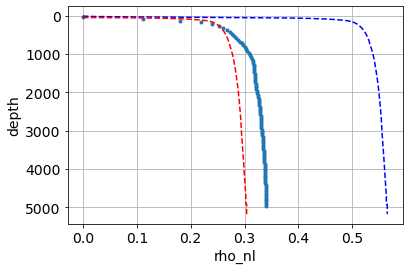

In [24]:
(dsbrt.rho_hm-dsbrt.rho_hm.isel(Z=0)).plot(y="Z",label="E",ls='',marker='.')
(dso.rho_nl.mean("station").isel(depth=slice(10,None,None))-dso.rho_nl.mean("station").isel(depth=10)).plot(y="depth",color="b",ls="--",label="SO-CHIC CTDs-linear EOS")
(dso.rho_nl.mean("station").isel(depth=slice(46,None,None))-dso.rho_nl.mean("station").isel(depth=46)).plot(y="depth",color="r",ls="--",label="SO-CHIC CTDs-linear EOS")
#plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.grid()


# Analysis

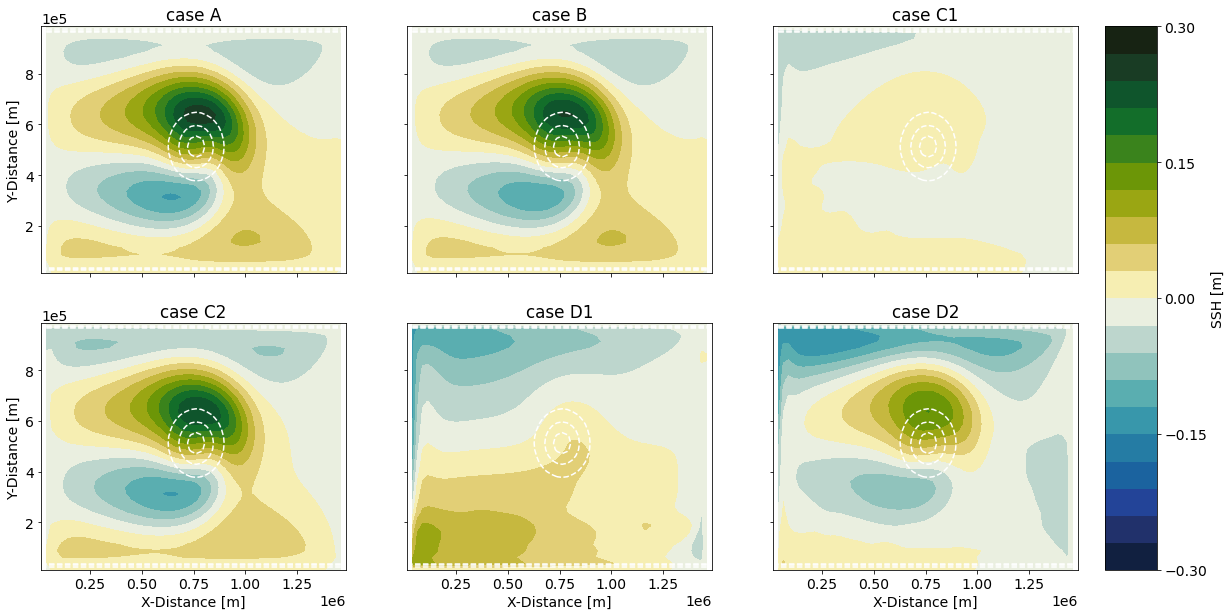

In [25]:
#plot SSH at last time step
t=-1
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=21

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)

gs1 = GridSpecFromSubplotSpec(2,3, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1], height_ratios=[1])


ax = fig.add_subplot(gs1[0,0])
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'Barotrop \n uni; day: {dsbb.day.isel(T=t).values}')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])

ax = fig.add_subplot(gs1[0,1])
(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'20layers \n uni; day: {dsb2u.day.isel(T=t).values}')
ax.set_title(f'case B')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')

ax = fig.add_subplot(gs1[0,2])
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.1,.1,3)})
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'20 l w meridi grad\n tw; day: {dsb2t.day.isel(T=t).values}')
ax.set_title(f'case C1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')

ax = fig.add_subplot(gs1[1,0])
(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'20 l w meridi grad\n tw +uni; day: {dsb2tu.day.isel(T=t).values}')
ax.set_title(f'case C2')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])

ax = fig.add_subplot(gs1[1,1])
(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'e-scale \n tw; day: {dsbet.day.isel(T=t).values}')
ax.set_title(f'case D1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax = fig.add_subplot(gs1[1,2])
cb=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=58)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
#ax.set_title(f'e-scale \n tw +uni; day: {dsbetu.day.isel(T=t).values}')
ax.set_title(f'case D2')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

plt.colorbar(cb,cax=fig.add_subplot(gs2[0]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")

plt.savefig('figures/SSH_finalstep.jpg',dpi=300)

In [26]:
#print(t)
t=-10
a=(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
t=-30
b=(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
c2=(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
d2=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=t,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
#print(a,b)
print((a-b)/a)
#print(a,c2)
print((a-c2)/a)
print((b-c2)/b)
print((a-d2)/a)

0.05484646
0.07255089
0.018731805
0.41451755


In [27]:
# Identify equilibrium /steady state

(-0.02, 0.02)

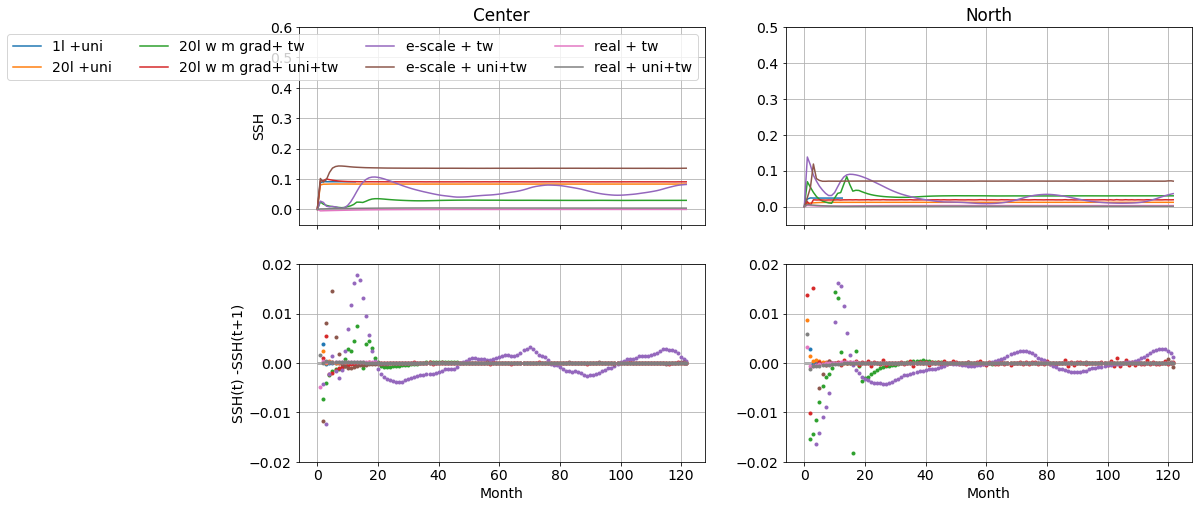

In [28]:
fig,axes=plt.subplots(2,2,figsize=(16,8))
xx=30
yy=20
eta_crit=0.00025

ax=axes[0,0]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label='1l +uni')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax, label='20l +uni')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="20l w m grad+ tw")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="20l w m grad+ uni+tw")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="e-scale + tw")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="e-scale + uni+tw")
dsbrt.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="real + tw")
dsbrtu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="real + uni+tw")
ax.grid()
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('SSH')
ax.set_title('Center')
ax.set_ylim(-0.05,.6)
ax.legend(ncol=4)#,bbox_to_anchor=[0.2,1.3])


ax=axes[1,0]
(dsbb.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label='1l +uni',ls='',marker='.')
(dsb2u.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax, label='20l +uni',ls='',marker='.')
(dsb2t.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="20l w m grad+ tw",ls='',marker='.')
(dsb2tu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="20l w m grad+ uni+tw",ls='',marker='.')
(dsbet.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="e-scale + tw",ls='',marker='.')
(dsbetu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="e-scale + uni+tw",ls='',marker='.')
(dsbrt.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="real + tw",ls='',marker='.')
(dsbrtu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="real + uni+tw",ls='',marker='.')
ax.fill_between(x=dsb2u.month, y1=eta_crit,y2=-1*eta_crit,color='grey',alpha=0.5)
ax.grid()
ax.set_xlabel('Month')
ax.set_ylabel('SSH(t) -SSH(t+1)')
ax.set_title('')
ax.set_ylim(-0.02,.02)

xx=30
yy=26


ax=axes[0,1]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label='1l +uni')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax, label='20l +uni')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="20l w m grad+ tw")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="20l w m grad+ uni+tw")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="e-scale + tw")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="e-scale + uni+tw")
dsbrt.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="real + tw")
dsbrtu.Eta.isel(X=xx,Y=yy).plot(x="month",ax=ax,label="real + uni+tw")
ax.grid()
ax.set_xticklabels('')
ax.set_ylim(-0.05,.5)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('North')
#ax.legend(ncol=2,bbox_to_anchor=[0.1,1])


ax=axes[1,1]

(dsbb.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label='1l +uni',ls='',marker='.')
(dsb2u.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax, label='20l +uni',ls='',marker='.')
(dsb2t.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="20l w m grad+ tw",ls='',marker='.')
(dsb2tu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="20l w m grad+ uni+tw",ls='',marker='.')
(dsbet.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="e-scale + tw",ls='',marker='.')
(dsbetu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="e-scale + uni+tw",ls='',marker='.')
(dsbrt.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="real + tw",ls='',marker='.')
(dsbrtu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",ax=ax,label="real + uni+tw",ls='',marker='.')
ax.fill_between(x=dsb2u.month, y1=eta_crit,y2=-1*eta_crit,color='grey',alpha=0.5)
ax.grid()
ax.set_xlabel('Month')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim(-0.02,.02)

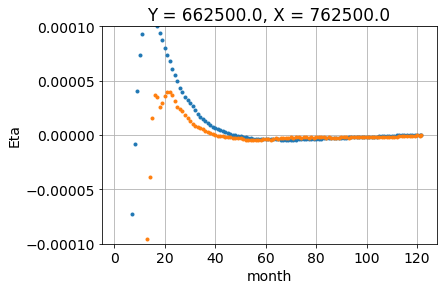

In [29]:
(dsbrt.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",label="real + tw",ls='',marker='.')
(dsbrtu.Eta.isel(X=xx,Y=yy).diff("T")).plot(x="month",label="real + uni+tw",ls='',marker='.')
plt.ylim(-.0001,.0001)
plt.grid()

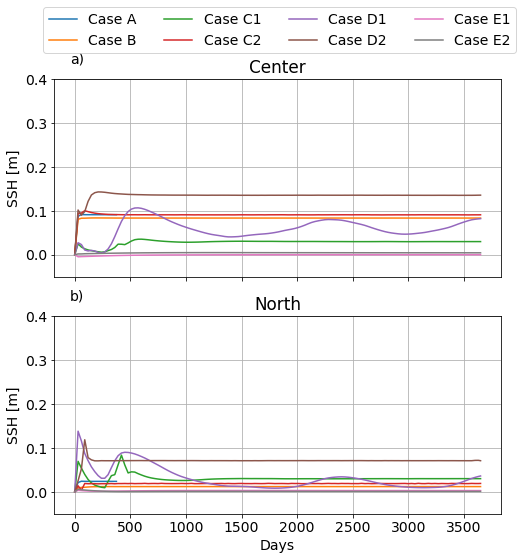

In [30]:
fig,axes=plt.subplots(2,1,figsize=(8,8))
xx=30
yy=20
eta_crit=0.00025

ax=axes[0]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label='Case A')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax, label='Case B')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case C1")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case C2")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case D1")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case D2")
dsbrt.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case E1")
dsbrtu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case E2")
ax.grid()
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('SSH [m]')
ax.set_title('Center')
ax.set_ylim(-0.05,.4)
ax.legend(ncol=4,bbox_to_anchor=[1.05,1.4])



xx=30
yy=26
ax=axes[1]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label='1l +uni')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax, label='20l +uni')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ tw")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ uni+tw")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + tw")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + uni+tw")
dsbrt.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="Case E1")
dsbrtu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="case E2")
ax.grid()
#ax.set_xticklabels('')
ax.set_ylim(-0.05,.4)
ax.set_xlabel('Days')
ax.set_ylabel('SSH [m]')
ax.set_title('North')

axes[0].text(0.05, 1.1, 'a)', horizontalalignment='center',verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(0.05, 1.1, 'b)', horizontalalignment='center',verticalalignment='center', transform=axes[1].transAxes)
plt.savefig('figures/equilibrium_A_D2.jpg',dpi=300)

Text(0.5, 1.0, 'North')

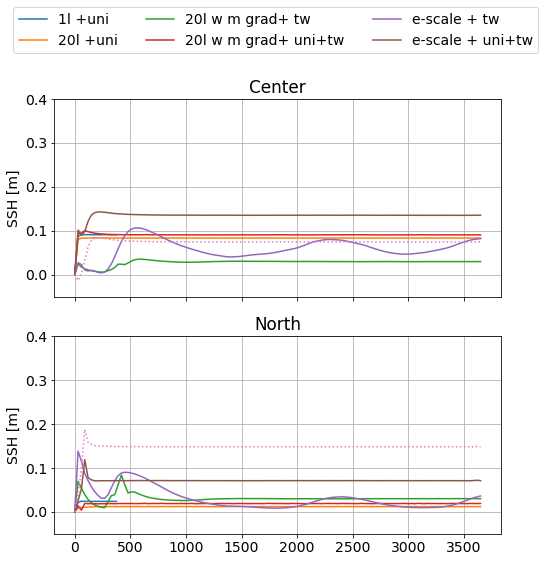

In [31]:
fig,axes=plt.subplots(2,1,figsize=(8,8))
xx=30
yy=20
eta_crit=0.00025

ax=axes[0]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label='1l +uni')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax, label='20l +uni')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ tw")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ uni+tw")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + tw")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + uni+tw")
(dsbetu.Eta.isel(X=xx,Y=yy)-dsbetu.Eta.isel(X=58,Y=yy).values).plot(x="day",ax=ax,linestyle=':')
ax.grid()
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylabel('SSH [m]')
ax.set_title('Center')
ax.set_ylim(-0.05,.4)
ax.legend(ncol=3,bbox_to_anchor=[1.1,1.5])



xx=30
yy=26
ax=axes[1]
dsbb.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label='1l +uni')
dsb2u.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax, label='20l +uni')
dsb2t.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ tw")
dsb2tu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="20l w m grad+ uni+tw")
dsbet.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + tw")
dsbetu.Eta.isel(X=xx,Y=yy).plot(x="day",ax=ax,label="e-scale + uni+tw")
(dsbetu.Eta.isel(X=xx,Y=yy)-dsbetu.Eta.isel(X=58,Y=yy).values).plot(x="day",ax=ax,linestyle=':')
ax.grid()
#ax.set_xticklabels('')
ax.set_ylim(-0.05,.4)
ax.set_xlabel('')
ax.set_ylabel('SSH [m]')
ax.set_title('North')

In [32]:
# print month when steady state is reached
tss=20
xx=30
yy=20
print(dsbb.Depth.isel(X=xx,Y=yy).values)
print(f"1 layer +uniform :{dsbb.month.where(np.abs(dsbb.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}") #
print(f"20 layer +uniform :{dsb2u.month.where(np.abs(dsb2u.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"20 layer with meridional gradient + thermal wind :{dsb2t.month.where(np.abs(dsb2t.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"20 layer with meridional gradient + thermal wind+uniform :{dsb2tu.month.where(np.abs(dsb2tu.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"e-scale + thermal wind :{dsbet.month.where(np.abs(dsbet.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"e-scale + thermal wind+uniform :{dsbetu.month.where(np.abs(dsbetu.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")

2000.0
1 layer +uniform :[ 4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5]
20 layer +uniform :[ 3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21.
 22. 23.]
20 layer with meridional gradient + thermal wind :[14. 20. 32. 33. 34. 35. 36. 37. 38. 41. 42. 43. 44. 45. 46. 47. 48. 49.
 50. 51.]
20 layer with meridional gradient + thermal wind+uniform :[11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30.]
e-scale + thermal wind :[ 47.  77.  99. 100.]
e-scale + thermal wind+uniform :[ 8. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35.]


In [33]:
# print month when steady state is reached
tss=20
xx=30
yy=26
print(f"1 layer +uniform :{dsbb.month.where(np.abs(dsbb.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}") #
print(f"20 layer +uniform :{dsb2u.month.where(np.abs(dsb2u.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"20 layer with meridional gradient + thermal wind :{dsb2t.month.where(np.abs(dsb2t.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"20 layer with meridional gradient + thermal wind+uniform :{dsb2tu.month.where(np.abs(dsb2tu.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"e-scale + thermal wind :{dsbet.month.where(np.abs(dsbet.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")
print(f"e-scale + thermal wind+uniform :{dsbetu.month.where(np.abs(dsbetu.Eta.isel(X=xx,Y=yy).diff('T'))<eta_crit,drop=True).values[0:tss]}")

1 layer +uniform :[ 3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  12.5]
20 layer +uniform :[ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.
 24. 25.]
20 layer with meridional gradient + thermal wind :[32. 33. 34. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57.
 58. 59.]
20 layer with meridional gradient + thermal wind+uniform :[ 5.  6.  9. 10. 14. 15. 16. 19. 20. 24. 25. 28. 29. 30. 31. 32. 33. 34.
 37. 38.]
e-scale + thermal wind :[  9.  47.  48.  49.  50.  60.  61.  80. 103. 104. 105. 106. 107. 108.]
e-scale + thermal wind+uniform :[ 7.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27.]


<ipython-input-34-8542e55b876e>:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


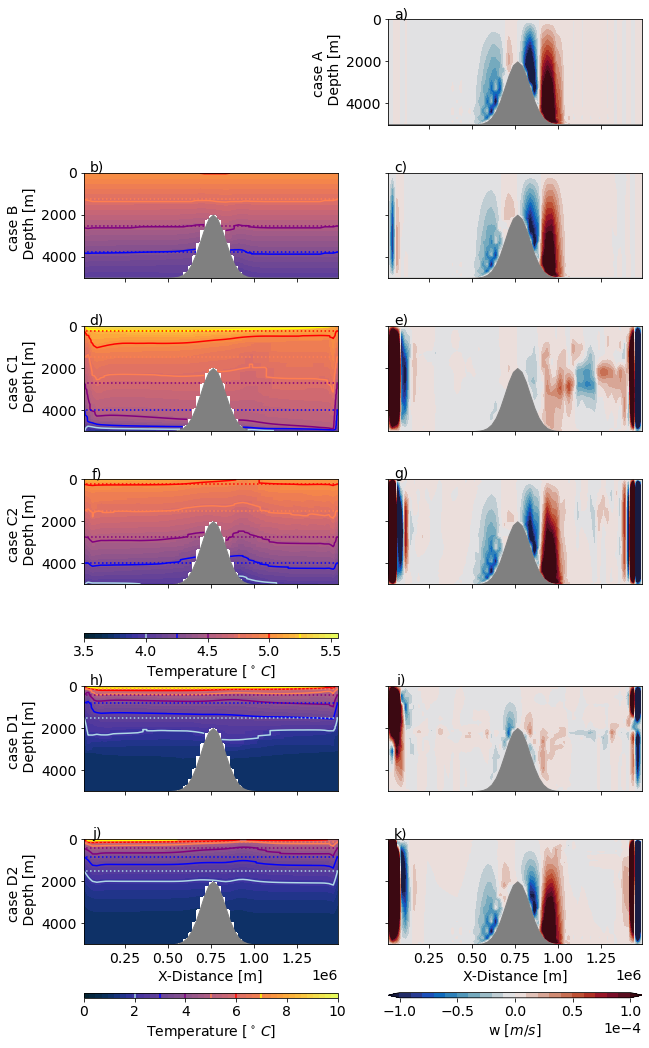

In [34]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

#plot T section  for 20 layer cases
t=-1
arr=3
tmin1=3.5
tmax1=5.55
cmapt1=cmo.thermal
levt1=43

# T for e-scale case
tmin2=0
tmax2=10
levt2=43

#plot Wsection  for 20 layer cases
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(8,2,figsize=(10,18),gridspec_kw={'width_ratios':[1,1],'height_ratios':[1,1,1,1,0.05,1,1,.05],'hspace':.6})
axes[0,0].axis('off')

ax = axes[0,1]
dsbb.W.isel(T=-1,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('case A \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#---------------- case B -----------------------

ax = axes[1,0]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.set_title(f'')
ax.set_ylabel('case B \n Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = axes[1,1]
dsb2u.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#-------------------------- case C1 ---------------------
ax = axes[2,0]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C1 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[2,1]
cb=(dsb2t.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


#------------------ case c2-----------------------------------

ax = axes[3,0]
cbt1=(dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
cctt1=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsb2tu.X,(dsb2tu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax =  axes[3,1]
cb=(dsb2tu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2tu.X,(dsb2tu.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

cbar1=plt.colorbar(cbt1,cax=axes[4,0],orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar1.add_lines(cctt1)
axes[4,1].axis('off')

# ------------case D1 --------------------------------------

ax = axes[5,0]
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbet.Temp.where(dsbet.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.set_title(f'')
ax.set_xlabel('')#X-Distance [m]')
ax.set_ylabel('case D1 \n Depth [m]')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[5,1]
dsbet.W.isel(T=t,Y=20).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'i)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


# ------------------ case D2 ----------------------------
ax =axes[6,0]
cbt2=(dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
cctt2=dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbetu.Temp.where(dsbetu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('case D2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'j)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[6,1]
cbw=(dsbetu.W.isel(T=t,Y=20)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
#ax.set_title(f' e-scale \n thermal wind + uniform \n day: {dsbetu.day.isel(T=t).values}')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.text(0.05, 1.05, 'k)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


cbar2=plt.colorbar(cbt2,cax=axes[7,0], orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(tmin2,tmax2,6))
cbar2.add_lines(cctt2)
cbar3=plt.colorbar(cbw,cax=axes[7,1], orientation="horizontal", ticks=np.linspace(wmin,wmax,5),label="w [$m/s$]",format=cbformat)

plt.tight_layout()
plt.savefig('figures/TW_sections_alongx.jpg',dpi=300)
#plt.savefig('figures/T_sections_alongx.jpg',dpi=300)

<ipython-input-35-301c78a918f8>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


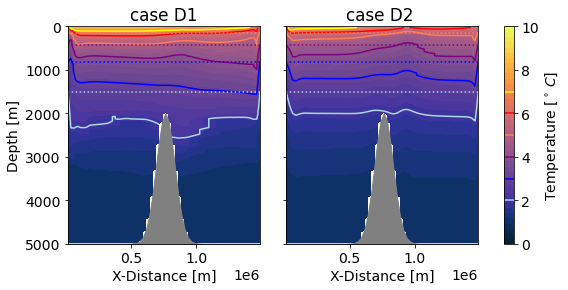

In [35]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

#plot T section  for 20 layer cases
t=-1
arr=3
tmin1=3.5
tmax1=5.55
cmapt1=cmo.thermal
levt1=43

# T for e-scale case
tmin2=0
tmax2=10
levt2=43

#plot Wsection  for 20 layer cases
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(1,3,figsize=(8,4),gridspec_kw={'width_ratios':[1,1,0.05],'height_ratios':[1],'hspace':.6})

# ------------------ case D2 ----------------------------
ax =axes[0]
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.X,(dsb2u.Depth).isel(Y=20),5000,color='grey')
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbet.Temp.where(dsbet.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.set_title(f'case D1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Depth [m]')

ax.set_ylim((5000,0))
#ax.text(0.05, 1.05, 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[1]
cbt2=(dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20)).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
cctt2=dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbetu.Temp.where(dsbetu.Temp>0).isel(T=0,Y=20).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.fill_between(dsbb.X,(dsbb.Depth).isel(Y=20),5000,color='grey')
ax.set_title(f'case D2 ')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_ylim((5000,0))
#ax.text(0.05, 1.05, 'j)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

cbar2=plt.colorbar(cbt2,cax=axes[2],label='Temperature [$^\circ\,C$]',ticks=np.linspace(tmin2,tmax2,6))
cbar2.add_lines(cctt2)


plt.tight_layout()
plt.savefig('figures/TW_sections_alongx_caseD.jpg',dpi=300)
#plt.savefig('figures/T_sections_alongx.jpg',dpi=300)

<ipython-input-36-52c2bb159fa9>:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


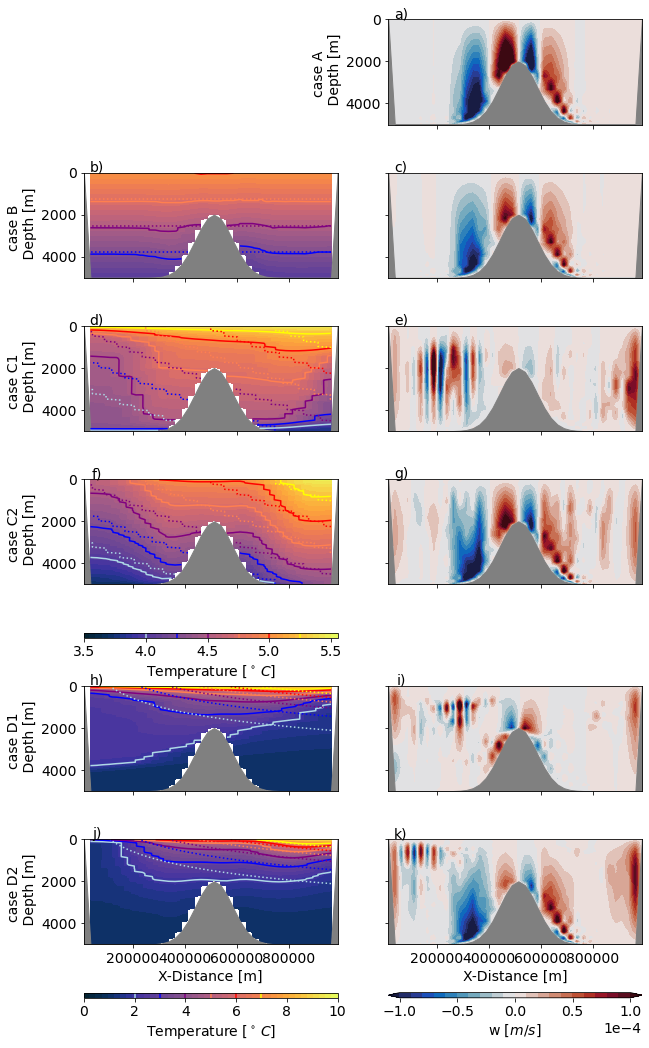

In [36]:
import matplotlib.ticker                         # here's where the formatter is
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))                 # set the limits for sci. not.

#plot T section  for 20 layer cases
t=-1
arr=3
tmin1=3.5
tmax1=5.55
cmapt1=cmo.thermal
levt1=43

# T for e-scale case
tmin2=0
tmax2=10
levt2=43

#plot Wsection  for 20 layer cases
wmin=-0.0001
wmax=0.0001
cmap2=cmo.balance
lev=21

fig,axes=plt.subplots(8,2,figsize=(10,18),gridspec_kw={'width_ratios':[1,1],'height_ratios':[1,1,1,1,0.05,1,1,.05],'hspace':.6})
axes[0,0].axis('off')

ax = axes[0,1]
dsbb.W.isel(T=-1,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.Y,(dsb2u.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('case A \n Depth [m]')
ax.set_ylim((5000,0))
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#---------------- case B -----------------------

ax = axes[1,0]
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.Y,(dsb2u.Depth).isel(X=30),5000,color='grey')
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2u.Temp.where(dsb2u.Temp>0).isel(T=0,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.set_title(f'')
ax.set_ylabel('case B \n Depth [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = axes[1,1]
dsb2u.W.isel(T=t,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2u.Y,(dsb2u.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

#-------------------------- case C1 ---------------------
ax = axes[2,0]
cb=(dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2t.Temp.where(dsb2t.Temp>0).isel(T=0,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsbb.Y,(dsbb.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C1 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[2,1]
cb=(dsb2t.W.isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.Y,(dsbb.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(0.05, 1.05, 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


#------------------ case c2-----------------------------------

ax = axes[3,0]
cbt1=(dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmapt1,vmin=tmin1,vmax=tmax1,levels=levt1,ax=ax,add_colorbar=False)
cctt1=dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25])
dsb2tu.Temp.where(dsb2tu.Temp>0).isel(T=0,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[4.0,4.25,4.5,4.75,5,5.25],linestyles=':')
ax.fill_between(dsb2tu.Y,(dsb2tu.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('case C2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax =  axes[3,1]
cb=(dsb2tu.W.isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsb2tu.Y,(dsb2tu.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

cbar1=plt.colorbar(cbt1,cax=axes[4,0],orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(3.5,5.5,5))
cbar1.add_lines(cctt1)
axes[4,1].axis('off')

# ------------case D1 --------------------------------------

ax = axes[5,0]
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,X=30).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.Y,(dsb2u.Depth).isel(X=30),5000,color='grey')
dsbet.Temp.where(dsbet.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbet.Temp.where(dsbet.Temp>0).isel(T=0,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.set_title(f'')
ax.set_xlabel('')#X-Distance [m]')
ax.set_ylabel('case D1 \n Depth [m]')
ax.set_xticklabels('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[5,1]
dsbet.W.isel(T=t,X=30).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbet.Y,(dsb2u.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'i)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


# ------------------ case D2 ----------------------------
ax =axes[6,0]
cbt2=(dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmapt1,vmin=tmin2,vmax=tmax2,levels=levt2,ax=ax,add_colorbar=False)
cctt2=dsbetu.Temp.where(dsbetu.Temp>0).isel(T=t,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7])
dsbetu.Temp.where(dsbetu.Temp>0).isel(T=0,X=30).plot.contour(ax=ax,colors=['lightblue','b','purple','coral','r','yellow'],levels=[2,3,4,5,6,7],linestyles=':')
ax.fill_between(dsbb.Y,(dsbb.Depth).isel(X=30),5000,color='grey')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('case D2 \n Depth [m]')
ax.set_ylim((5000,0))
ax.text(0.05, 1.05, 'j)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = axes[6,1]
cbw=(dsbetu.W.isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
ax.fill_between(dsbb.Y,(dsbb.Depth).isel(X=30),5000,color='grey')
#ax.set_title(f' e-scale \n thermal wind + uniform \n day: {dsbetu.day.isel(T=t).values}')
ax.set_title(f'')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_ylim((5000,0))
ax.set_yticklabels('')
ax.text(0.05, 1.05, 'k)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


cbar2=plt.colorbar(cbt2,cax=axes[7,0], orientation="horizontal",label='Temperature [$^\circ\,C$]',ticks=np.linspace(tmin2,tmax2,6))
cbar2.add_lines(cctt2)
cbar3=plt.colorbar(cbw,cax=axes[7,1], orientation="horizontal", ticks=np.linspace(wmin,wmax,5),label="w [$m/s$]",format=cbformat)

plt.tight_layout()
plt.savefig('figures/TW_sections_alongy.jpg',dpi=300)
#plt.savefig('figures/T_sections_alongx.jpg',dpi=300)

In [37]:
# compute streamfunctions for all along U since the boundaries are closed
dsbb['psi'] = grid.cumint(-grid.integrate(dsbb.U,'Z'),'Y', boundary='fill')/1e6
dsb2u['psi'] = grid.cumint(-grid.integrate(dsb2u.U,'Z'),'Y', boundary='fill')/1e6
dsb2t['psi'] = grid.cumint(-grid.integrate(dsb2t.U,'Z'),'Y', boundary='fill')/1e6

dsb2tu['psi'] = grid.cumint(-grid.integrate(dsb2tu.U,'Z'),'Y', boundary='fill')/1e6
dsbet['psi'] = grid.cumint(-grid.integrate(dsbet.U,'Z'),'Y', boundary='fill')/1e6
dsbetu['psi'] = grid.cumint(-grid.integrate(dsbetu.U,'Z'),'Y', boundary='fill')/1e6

# relative vorticity
dsbb['ze']=-1*grid.derivative(dsbb.U,'Y',boundary='extend')+(grid.derivative(dsbb.V,'X',boundary='extend'))
dsb2u['ze']=-1*grid.derivative(dsb2u.U,'Y',boundary='extend')+(grid.derivative(dsb2u.V,'X',boundary='extend'))
dsb2t['ze']=-1*grid.derivative(dsb2t.U,'Y',boundary='extend')+(grid.derivative(dsb2t.V,'X',boundary='extend'))

dsb2tu['ze']=-1*grid.derivative(dsb2tu.U,'Y',boundary='extend')+(grid.derivative(dsb2tu.V,'X',boundary='extend'))


In [38]:
dsbb['U_baro'] = (dsbb.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbb['V_baro'] = (dsbb.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2u['U_baro'] = (dsb2u.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2u['V_baro'] = (dsb2u.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsb2t['U_baro'] = (dsb2t.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2t['V_baro'] = (dsb2t.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsb2tu['U_baro'] = (dsb2tu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsb2tu['V_baro'] = (dsb2tu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbet['U_baro'] = (dsbet.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbet['V_baro'] = (dsbet.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbetu['U_baro'] = (dsbetu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbetu['V_baro'] = (dsbetu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

dsbrt['U_baro'] = (dsbrt.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrt['V_baro'] = (dsbrt.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')
dsbrtu['U_baro'] = (dsbrtu.U* dsbb.HFacW *dsbb.drU).sum(dim='Z')
dsbrtu['V_baro'] = (dsbrtu.V* dsbb.HFacS *dsbb.drV).sum(dim='Z')

In [39]:
dsbb['zeta_bt']= (-grid.diff(dsbb.U_baro * dsbb.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbb.V_baro * dsbb.dyC, 'X',boundary='extrapolate'))/dsbb.rAz

dsb2u['zeta_bt']= (-grid.diff(dsb2u.U_baro * dsb2u.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2u.V_baro * dsb2u.dyC, 'X',boundary='extrapolate'))/dsb2u.rAz
dsb2t['zeta_bt']= (-grid.diff(dsb2t.U_baro * dsb2t.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2t.V_baro * dsb2t.dyC, 'X',boundary='extrapolate'))/dsb2t.rAz
dsb2tu['zeta_bt']= (-grid.diff(dsb2tu.U_baro * dsb2tu.dxC, 'Y',boundary='extrapolate') + grid.diff(dsb2tu.V_baro * dsb2tu.dyC, 'X',boundary='extrapolate'))/dsb2tu.rAz

dsbet['zeta_bt']= (-grid.diff(dsbet.U_baro * dsbet.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbet.V_baro * dsbet.dyC, 'X',boundary='extrapolate'))/dsbet.rAz
dsbetu['zeta_bt']= (-grid.diff(dsbetu.U_baro * dsbetu.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbetu.V_baro * dsbetu.dyC, 'X',boundary='extrapolate'))/dsbetu.rAz

dsbrt['zeta_bt']= (-grid.diff(dsbrt.U_baro * dsbrt.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbrt.V_baro * dsbrt.dyC, 'X',boundary='extrapolate'))/dsbrt.rAz
dsbrtu['zeta_bt']= (-grid.diff(dsbrtu.U_baro * dsbrtu.dxC, 'Y',boundary='extrapolate') + grid.diff(dsbrtu.V_baro * dsbrtu.dyC, 'X',boundary='extrapolate'))/dsbrtu.rAz





[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

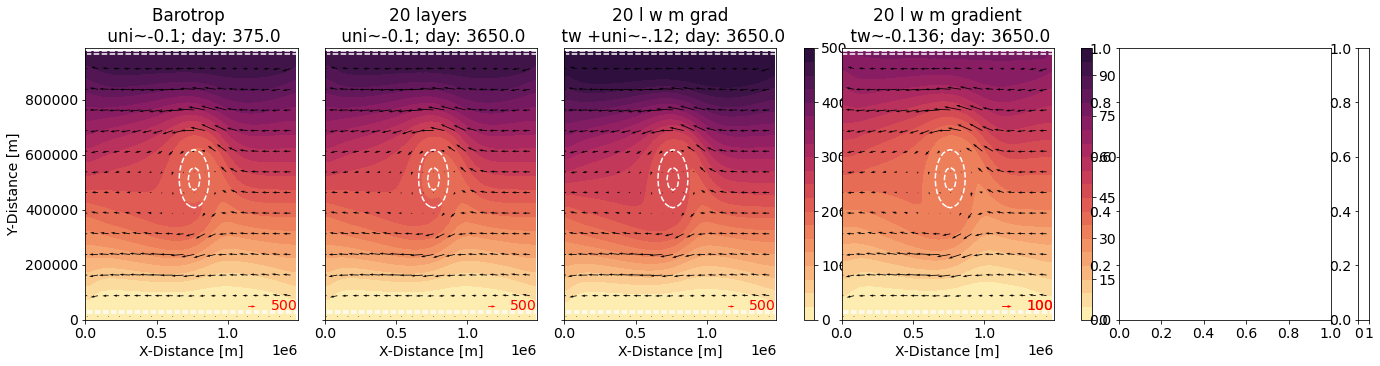

In [40]:
#plot streamfunction at last time step
wmin=0
wmax=500
lev=21
t=-1
cmap2=cmo.matter
fig,axes=plt.subplots(1,8,figsize=(23,5),gridspec_kw={'width_ratios':[1,1,1,0.05,1,0.05,1,.05]})
ax=axes[0]
dsbb.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'Barotrop \n uni~-0.1; day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1]
cb=(dsb2u.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2u.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2u.X[0:-1:arr],dsb2u.Y[0:-1:arr],grid.interp(dsb2u.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2u.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 layers \n uni~-0.1; day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[2]
(dsb2tu.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2tu.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2tu.X[0:-1:arr],dsb2tu.Y[0:-1:arr],grid.interp(dsb2tu.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2tu.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 l w m grad\n tw +uni~-.12; day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('') 
plt.colorbar(cb,cax=axes[3], label='',ticks=np.linspace(0,500,6))

ax=axes[4]
cb1=(dsb2t.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin*.2,vmax=wmax*.2,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsb2t.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 l w m gradient\n tw~-0.02; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

plt.colorbar(cb1,cax=axes[5], label='Streamfunction [Sv]')

#ax=axes[6]
#cb2=(dsb2t01.psi.isel(T=t)).plot.contourf(cmap=cmap2,ax=ax,vmin=0,vmax=wmax*2,levels=lev,add_colorbar=False)#cbar_kwargs={'label':''})
#dsb2t01.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
#q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'20 l w m gradient\n tw~-0.136; day: {dsb2t.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
#plt.colorbar(cb2,cax=axes[7], label='Streamfunction [Sv]')

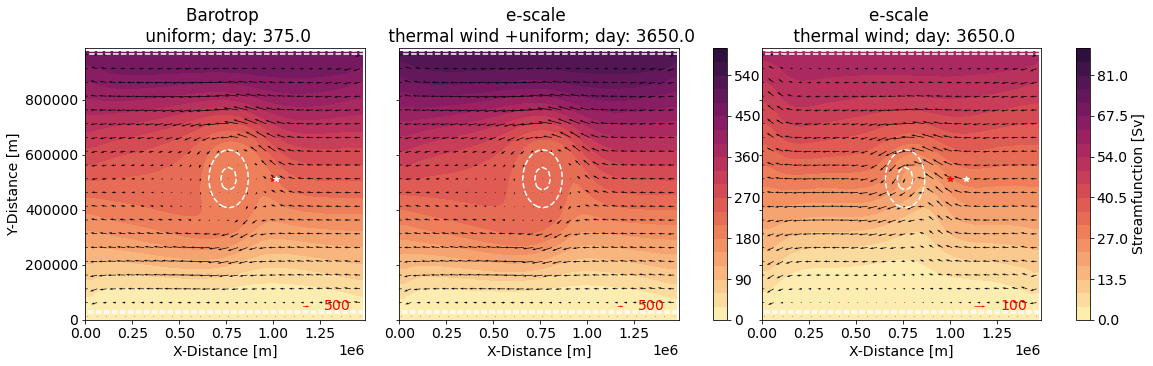

In [41]:
#plot streamfunction at last time step
wmin=0
wmax=600
lev=21
t=-1
arr=2
cmap2=cmo.matter
fig,axes=plt.subplots(1,5,figsize=(18,5),gridspec_kw={'width_ratios':[1,1,0.05,1,0.05]})
ax=axes[0]
dsbb.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.plot(dsbb.X_left.isel(X_left=40),dsbb.Y.isel(Y=20),marker='*',color='r')
ax.plot(dsbb.X.isel(X=40),dsbb.Y.isel(Y=20),marker='*',color='w')
ax.set_title(f'Barotrop \n uniform; day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')


ax=axes[1]
cb=(dsbetu.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbetu.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbetu.X[0:-1:arr],dsbetu.Y[0:-1:arr],grid.interp(dsbetu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbetu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,500,label='$500$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'e-scale \n thermal wind +uniform; day: {dsb2tu.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('') 
plt.colorbar(cb,cax=axes[2], label='')

ax=axes[3]
cb=(dsbet.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*.15,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':''})
dsbet.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbet.X[0:-1:arr],dsbet.Y[0:-1:arr],grid.interp(dsbet.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbet.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,100,label='$100$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)

ax.plot(dsbb.X_left.isel(X_left=40),dsbb.Y.isel(Y=20),marker='*',color='r')
ax.plot(dsbb.X.isel(X=43),dsbb.Y.isel(Y=20),marker='*',color='w')
ax.set_title(f'e-scale \n thermal wind; day: {dsb2u.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')



plt.colorbar(cb,cax=axes[4], label='Streamfunction [Sv]')

# Can we disentangle the  barotropic and baroclinic contribution in cases C1 and  C2

Text(0.5, 1.0, '')

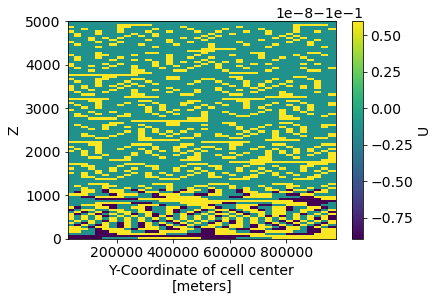

In [42]:
(dsb2tu.U.isel(X_left=59,T=0,Y=slice(1,-1))-dsb2t.U.isel(X_left=59,T=0,Y=slice(1,-1))).plot.pcolormesh()
plt.title('')

In [43]:
#compute difference in SSH by removing the thermal wind component from the full SSH
bt_comp=(dsb2tu.Eta-dsb2t.Eta)


In [44]:
t=-1
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=21

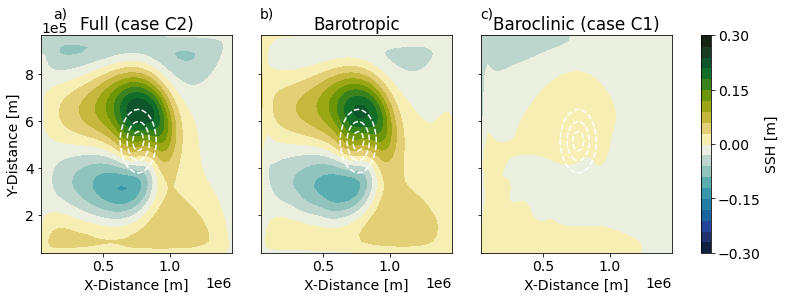

In [45]:
etamin=-0.3
etamax=0.3
etalev=21
etamap=cmo.delta
fig,axes=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios':[1,1,1,.05]})
ax=axes[0]
cb=(dsb2tu.Eta-dsb2tu.Eta.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Full (case C2)')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.text(0.1, 1.1, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[1]
(bt_comp-bt_comp.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Barotropic')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax=axes[2]
(dsb2t.Eta-dsb2t.Eta.isel(X=58)).isel(X=slice(1,-1),Y=slice(1,-1),T=-1).plot.contourf(ax=ax,vmin=etamin,vmax=etamax,levels=etalev,cmap=etamap,add_colorbar=False)
dsb2t.Depth.isel(X=slice(1,59),Y=slice(1,-1)).plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title('Baroclinic (case C1)')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xlabel('X-Distance [m]')
ax.text(0.03, 1.1, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb,cax=axes[3],label='SSH [m]',ticks=np.linspace(-0.3,0.3,5)) 
plt.savefig('figures/20l_split_comp.jpg',dpi=300)

In [46]:
full_end=(dsb2tu.Eta-dsb2tu.Eta.isel(X=58))#.isel(T=-1)
bt_end=(bt_comp-bt_comp.isel(X=58))#.isel(T=-1)
bc_end=(dsb2t.Eta-dsb2t.Eta.isel(X=58))#.isel(T=-1)

# Further analysis

In [47]:
# I think you are probably right but you have not shown that at all.
# What about a plot of the SSH signal (to be determine) versus the velocity near top of the bump (and also bottom of the bump)?
np.linspace(-.3,.3,7)


array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3])

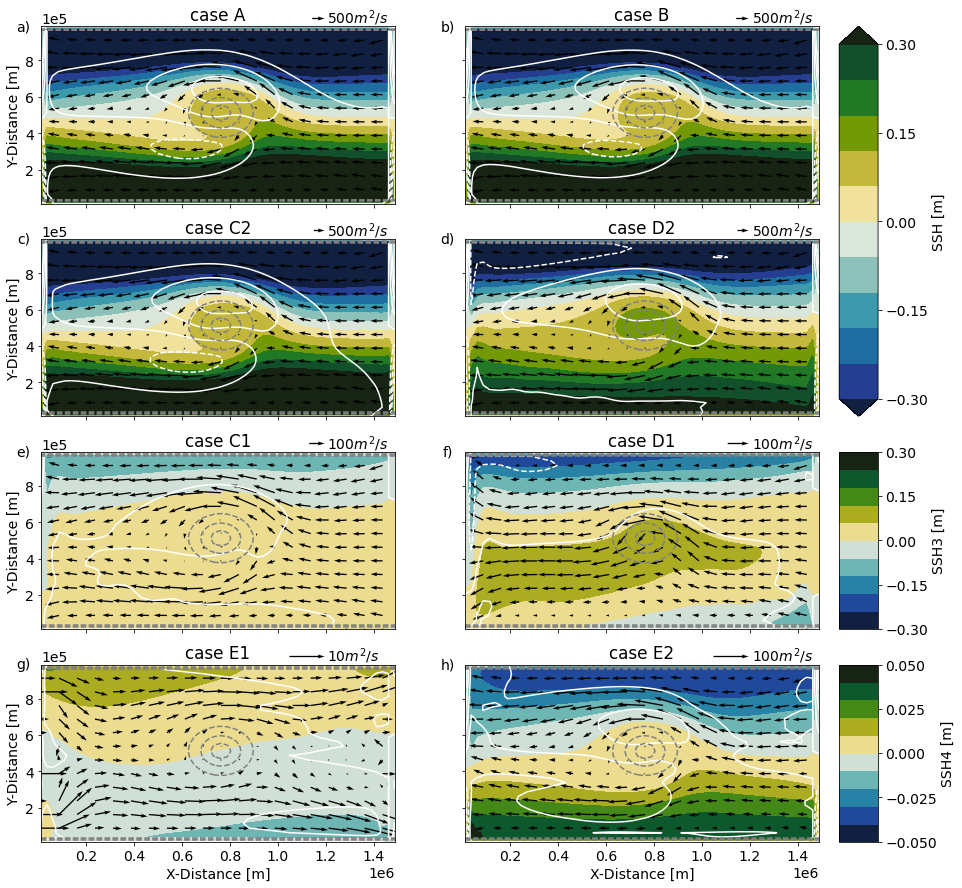

In [48]:
#plot SSH at last time step
xx=58 # Location to remove the gradient
t=-1
arr=3
cmap2=cmo.delta
lev=11
fig = plt.figure(figsize=(15,15))
gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)

gs1 = GridSpecFromSubplotSpec(4,2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(4,1, subplot_spec=gs[1])

wmin=-.3
wmax=-1*wmin
levl=np.linspace(wmin,wmax,7)

ax = fig.add_subplot(gs1[0,0])
dsbb.Eta.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[0,1])
(dsb2u.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2u.X[0:-1:arr],dsb2u.Y[0:-1:arr],grid.interp(dsb2u.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2u.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case B')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[1,0])
(dsb2tu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2tu.X[0:-1:arr],dsb2tu.Y[0:-1:arr],grid.interp(dsb2tu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2tu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case C2')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[1,1])
cb=(dsbetu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbetu.X[0:-1:arr],dsbetu.Y[0:-1:arr],grid.interp(dsbetu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbetu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case D2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


plt.colorbar(cb,cax=fig.add_subplot(gs2[:2]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")


wmax=0.3
wmin=-1*wmax
levl=np.linspace(wmin,wmax,7)
ax = fig.add_subplot(gs1[2,0])
(dsb2t.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case C1')
ax.set_xlabel('')
#ax.set_ylabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


#ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])



ax = fig.add_subplot(gs1[2,1])
cb1=(dsbet.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbet.X[0:-1:arr],dsbet.Y[0:-1:arr],grid.interp(dsbet.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbet.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case D1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb1,cax=fig.add_subplot(gs2[2]), ticks=np.linspace(wmin,wmax,5),label="SSH3 [m]")



wmin=-0.05
wmax=-1*wmin
levl=np.linspace(wmin,wmax,11)

ax = fig.add_subplot(gs1[3,0])
(dsbrt.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbrt.X[0:-1:arr],dsbrt.Y[0:-1:arr],grid.interp(dsbrt.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrt.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,10,label='$10 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


ax = fig.add_subplot(gs1[3,1])
cb2=(dsbrtu.Eta.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)
(dsbrtu.Eta.isel(T=t)-dsbrtu.Eta.isel(T=-1,X=xx)).plot.contour(levels=levl,ax=ax,colors='w')
dsbrtu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='gray')
q=ax.quiver(dsbrtu.X[0:-1:arr],dsbrtu.Y[0:-1:arr],grid.interp(dsbrtu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrtu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
ax.set_title(f'case E2')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.text(-0.05, 1., 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb2,cax=fig.add_subplot(gs2[3]), ticks=np.linspace(wmin,wmax,5),label="SSH4 [m]")

plt.savefig('figures/SSH_finalstep_new_arr.jpg',dpi=300)

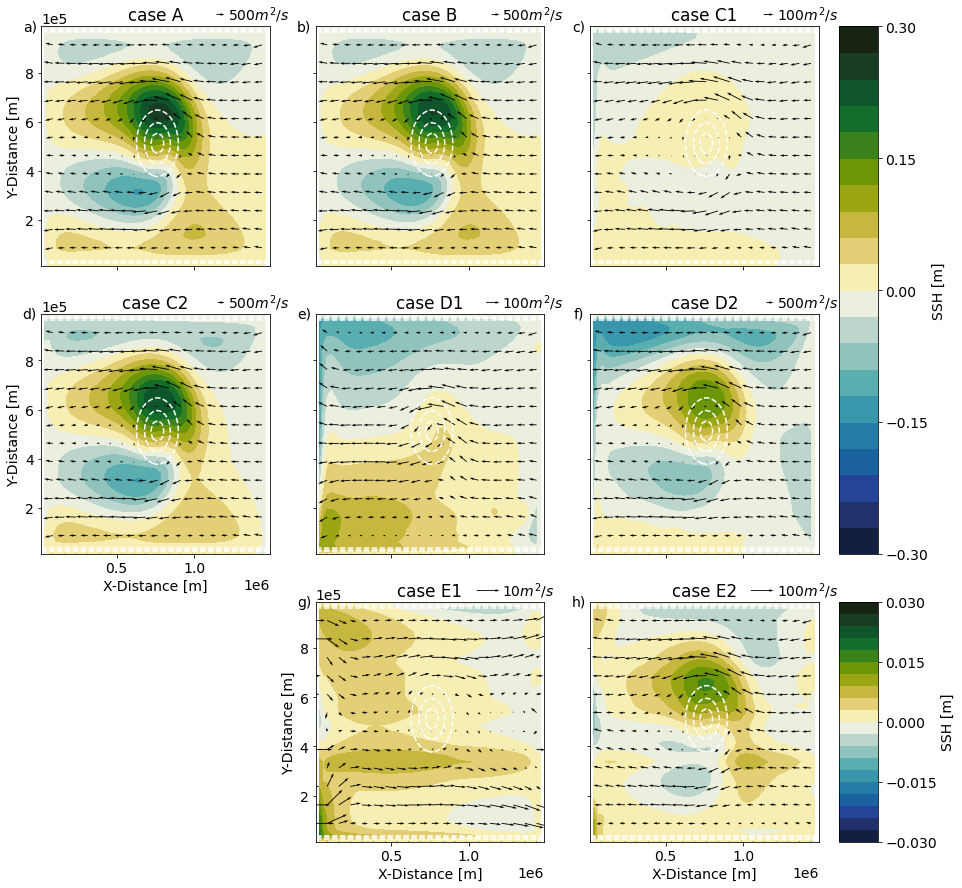

In [49]:
#plot SSH at last time step
xx=58 # Location to remove the gradient
t=-1
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=21

fig = plt.figure(figsize=(15,15))
gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)

gs1 = GridSpecFromSubplotSpec(3,3, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1], height_ratios=[1.,1.,1.])


ax = fig.add_subplot(gs1[0,0])
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[0,1])
(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2u.X[0:-1:arr],dsb2u.Y[0:-1:arr],grid.interp(dsb2u.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2u.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case B')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[0,2])
(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.1,.1,3)})
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2t.X[0:-1:arr],dsb2t.Y[0:-1:arr],grid.interp(dsb2t.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2t.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case C1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[1,0])
(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2tu.X[0:-1:arr],dsb2tu.Y[0:-1:arr],grid.interp(dsb2tu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2tu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case C2')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('X-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[1,1])
(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbet.X[0:-1:arr],dsbet.Y[0:-1:arr],grid.interp(dsbet.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbet.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case D1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[1,2])
cb=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbetu.X[0:-1:arr],dsbetu.Y[0:-1:arr],grid.interp(dsbetu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbetu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case D2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.colorbar(cb,cax=fig.add_subplot(gs2[:2]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")
wmin=-0.03
wmax=0.03

ax = fig.add_subplot(gs1[2,1])
(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbrt.X[0:-1:arr],dsbrt.Y[0:-1:arr],grid.interp(dsbrt.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrt.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,10,label='$10 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[2,2])
cb2=(dsbrtu.Eta.isel(T=t)-dsbrtu.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbrtu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbrtu.X[0:-1:arr],dsbrtu.Y[0:-1:arr],grid.interp(dsbrtu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbrtu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,1.05,100,label='$100 m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case E2')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
plt.colorbar(cb2,cax=fig.add_subplot(gs2[2]), ticks=np.linspace(wmin,wmax,5),label="SSH [m]")
ax.text(-0.05, 1., 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

plt.savefig('figures/SSH_anomaly_finalstep_new_arr.jpg',dpi=300)

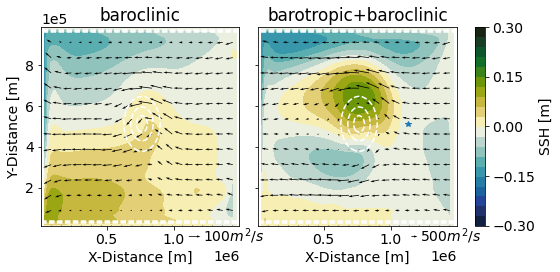

In [50]:
#plot SSH at last time step
xx=58 # Location to remove the gradient
t=-1
arr=3
wmin=-.3
wmax=-1*wmin
cmap2=cmo.delta
lev=21

fig,axes = plt.subplots(1,3,figsize=(8,4),gridspec_kw={'width_ratios':[1,1,0.05]})
#gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)



ax = axes[0]
(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbet.X[0:-1:arr],dsbet.Y[0:-1:arr],grid.interp(dsbet.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbet.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,-.05,100,label='$100m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'baroclinic')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
#ax.text(-0.05, 1., 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax = axes[1]
cb=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=xx)).isel(X=slice(1,-1)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbetu.X[0:-1:arr],dsbetu.Y[0:-1:arr],grid.interp(dsbetu.isel(T=t).U_baro,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbetu.isel(T=t).V_baro,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,-.05,500,label='$500m^2/s$',color='k',labelpos='E',labelcolor='k',labelsep=0.05)
#ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'barotropic+baroclinic')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
#ax.set_xticklabels('')
#ax.text(-0.05, 1., 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
plt.colorbar(cb,cax=axes[2], ticks=np.linspace(wmin,wmax,5),label="SSH [m]")
wmin=-0.03
wmax=0.03
plt.tight_layout()


plt.savefig('figures/SSH_finalstep_D1D2.jpg',dpi=300)

In [51]:
#extract max elevation in SSH field 
sshmax_A=(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_B=(dsb2u.Eta.isel(T=t)-dsb2u.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C1=(dsb2t.Eta.isel(T=t)-dsb2t.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_C2=(dsb2tu.Eta.isel(T=t)-dsb2tu.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_D1=(dsbet.Eta.isel(T=t)-dsbet.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_D2=(dsbetu.Eta.isel(T=t)-dsbetu.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_E1=(dsbrt.Eta.isel(T=t)-dsbrt.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values
sshmax_E2=(dsbrtu.Eta.isel(T=t)-dsbrtu.Eta.isel(T=-1,X=58)).isel(X=slice(10,-10),Y=slice(10,-5)).max().values



In [52]:
dsbb.Z.isel(Z=40)

<xarray.DataArray 'Z' ()>
array(2025.)
Coordinates:
    Z        float64 2.025e+03
Attributes:
    axis:     Z

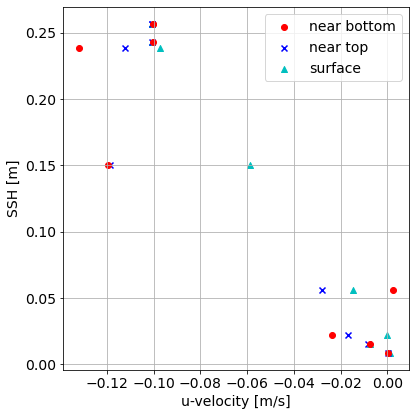

In [53]:
xx=45
plt.figure(figsize=(6,6))
plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_A,marker='o',color='r',label="near bottom")
plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_A,marker='x',color='b',label="near top")
plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_A,marker='^',color='c',label="surface")

# surface
plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_A,marker='^',color='c')
plt.scatter(dsb2u.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_B,marker='^',color='c')
plt.scatter(dsb2t.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_C1,marker='^',color='c')
plt.scatter(dsb2tu.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_C2,marker='^',color='c')
plt.scatter(dsbet.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_D1,marker='^',color='c')
plt.scatter(dsbetu.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_D2,marker='^',color='c')
plt.scatter(dsbrt.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_E1,marker='^',color='c')
plt.scatter(dsbrtu.U.isel(T=-1,X_left=xx,Y=20,Z=0).values,sshmax_E2,marker='^',color='c')

# near top velocity
plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_A,marker='x',color='b')
plt.scatter(dsb2u.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_B,marker='x',color='b')
plt.scatter(dsb2t.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_C1,marker='x',color='b')
plt.scatter(dsb2tu.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_C2,marker='x',color='b')
plt.scatter(dsbet.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_D1,marker='x',color='b')
plt.scatter(dsbetu.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_D2,marker='x',color='b')
plt.scatter(dsbrt.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_E1,marker='x',color='b')
plt.scatter(dsbrtu.U.isel(T=-1,X_left=xx,Y=20,Z=40).values,sshmax_E2,marker='x',color='b')
# near bottom velocity

plt.scatter(dsbb.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_A,marker='o',color='r')
plt.scatter(dsb2u.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_B,marker='o',color='r')
plt.scatter(dsb2t.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_C1,marker='o',color='r')
plt.scatter(dsb2tu.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_C2,marker='o',color='r')
plt.scatter(dsbet.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_D1,marker='o',color='r')
plt.scatter(dsbetu.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_D2,marker='o',color='r')
plt.scatter(dsbrt.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_E1,marker='o',color='r')
plt.scatter(dsbrtu.U.isel(T=-1,X_left=xx,Y=20,Z=99).values,sshmax_E2,marker='o',color='r')
plt.legend(bbox_to_anchor=[1,1])
plt.grid()
plt.ylabel('SSH [m]')
plt.xlabel('u-velocity [m/s]')

plt.tight_layout()

plt.savefig('./figures/scatter_SSH_u.jpg')

Text(0.5, 1.0, '')

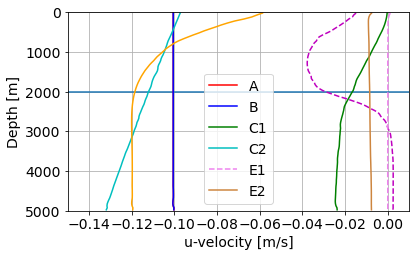

In [54]:
yy=20
xx=45
plt.figure()
dsbb.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='r',label="A")
dsb2u.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='b',label="B")
dsb2t.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='g',label="C1")
dsb2tu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='c',label="C2")
dsbet.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='m',label="",ls='--')
dsbetu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='orange',label="")
dsbrt.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='violet',label="E1",ls='--')
dsbrtu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='peru',label="E2")
plt.ylim(0,5000)
plt.gca().invert_yaxis()
plt.hlines(y=2000,xmin=-0.15,xmax=0.01)
plt.xlim(-0.15,0.01)
plt.legend()
plt.grid()
plt.ylabel('Depth [m]')
plt.xlabel('u-velocity [m/s]')
plt.tight_layout()
plt.title('')#f'X={dsbrtu.X_left.isel(X_left=xx).data},Y={dsbrtu.Y.isel(Y=yy).data}')
#plt.savefig('./figures/impinging_uvel_D1_D2.jpg',dpi=300)




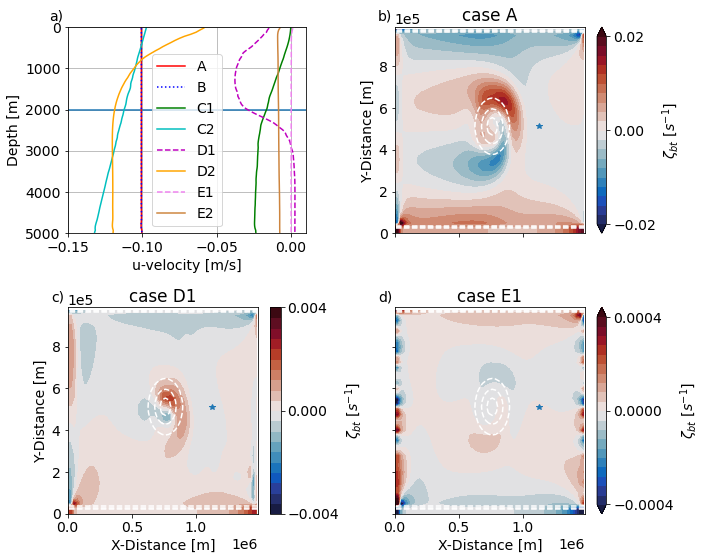

In [55]:
fig,axes = plt.subplots(2,2,figsize=(10,8))
ax=axes[0,0]
dsbb.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='r',label="A",ax=ax)
dsb2u.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='b',label="B",ax=ax,ls=':')
dsb2t.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='g',label="C1",ax=ax)
dsb2tu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='c',label="C2",ax=ax)
dsbet.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='m',label="D1",ls='--',ax=ax)
dsbetu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='orange',label="D2",ax=ax)
dsbrt.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='violet',label="E1",ls='--',ax=ax)
dsbrtu.U.isel(T=-1,X_left=xx,Y=yy).plot(y="Z",color='peru',label="E2",ax=ax)
ax.set_ylim(0,5000)
ax.invert_yaxis()
ax.hlines(y=2000,xmin=-0.15,xmax=0.01)
ax.set_xlim(-0.15,0.01)
ax.legend()
ax.grid()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('u-velocity [m/s]')
ax.set_title('')#f'X={dsbrtu.X_left.isel(X_left=xx).data},Y={dsbrtu.Y.isel(Y=yy).data}')
ax.text(-0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[0,1]
wmin=-.02
wmax=-1*wmin
cmap2=cmo.balance
lev=21
dsbb.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1,0]
wmin=wmin/5
wmax=wmax/5
dsbet.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case D1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1,1]
wmin=wmin/10
wmax=-1*wmin
dsbrt.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'$\\zeta_{bt}$ [$s^{-1}$]','ticks':np.linspace(wmin,wmax,3)})
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.plot(dsb2tu.X_left.isel(X_left=45),dsb2tu.Y.isel(Y=20),marker='*')
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.text(-0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()
plt.savefig('figures/U_zeta_baro.jpg',dpi=300)

In [56]:
(dsb2tu.X_left.isel(X_left=45)-dsb2tu.X.isel(X=30))

<xarray.DataArray ()>
array(362500.)
Coordinates:
    Xp1      float64 1.125e+06
    X_left   float64 1.125e+06
    X        float64 7.625e+05

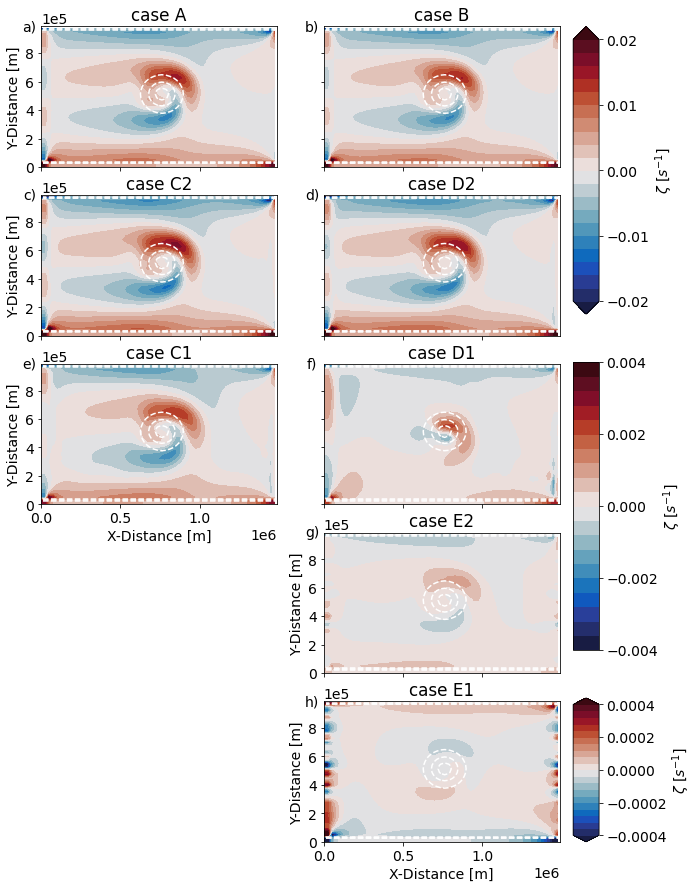

In [57]:
#plot SSH at last time step
xx=58 # Location to remove the gradient
t=-1
arr=3
wmin=-.02
wmax=-1*wmin
cmap2=cmo.balance
lev=21

fig = plt.figure(figsize=(10,15))
gs = GridSpec(1,2, width_ratios=[1,0.05],wspace=.05)

gs1 = GridSpecFromSubplotSpec(5, 2, subplot_spec=gs[0])
gs2 = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1], height_ratios=[2.,2.,1.])


# runs with strong impinging flow (A;B;C2;D2)
ax = fig.add_subplot(gs1[0,0])
cb=dsbb.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbb.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case A')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[0,1])
dsb2u.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2u.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case B')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[1,0])
dsb2tu.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsb2tu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case C2')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xticklabels('')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[1,1])
dsbetu.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbetu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case D2')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'd)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


plt.colorbar(cb,cax=fig.add_subplot(gs2[0]), ticks=np.linspace(wmin,wmax,5),label="$\\zeta$ [$s^{-1}$]")

# medium impinging flow (C1,D1,E2)
wmin=wmin/5
wmax=wmax/5
ax = fig.add_subplot(gs1[2,0])
cb2=dsb2t.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.1,.1,3)})
dsb2t.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case C1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'e)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[2,1])
dsbet.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbet.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case D1')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.text(-0.05, 1., 'f)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax = fig.add_subplot(gs1[3,1])
dsbrtu.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'SSH [m]','ticks':np.linspace(-.3,.3,3)})
dsbrtu.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case E2')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.set_xticklabels('')
ax.text(-0.05, 1., 'g)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)


plt.colorbar(cb2,cax=fig.add_subplot(gs2[1]), ticks=np.linspace(wmin,wmax,5),label="$\\zeta$ [$s^{-1}$]")
# weak impinging flow
wmin=wmin/10
wmax=-1*wmin

ax = fig.add_subplot(gs1[4,1])
cb3=dsbrt.zeta_bt.isel(T=-1).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,add_colorbar=False)#,cbar_kwargs={'label':'','ticks':np.linspace(-.3,.3,3)})
dsbrt.Depth.plot.contour(levels=[2500,3500,4500],ax=ax,linestyles='--',colors='w')
ax.set_title(f'case E1')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax.ticklabel_format(axis='y', style='scientific', scilimits=[-4,4])
ax.text(-0.05, 1., 'h)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.colorbar(cb3,cax=fig.add_subplot(gs2[2]), ticks=np.linspace(wmin,wmax,5),label="$\\zeta$ [$s^{-1}$]")

plt.savefig('figures/zeta_baro.jpg',dpi=300)